# 0.0. IMPORTS

In [1]:
import math
import pickle
import random
import inflection
import datetime
import numpy                as np
import pandas               as pd
import xgboost              as xgb
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gridspec

from scipy                  import stats
from boruta                 import BorutaPy
from IPython.display        import Image
from IPython.core.display   import HTML
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. HELPER FUNCTIONS

In [2]:
# ===================================================================
# Configura os gráficos
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    # Alterar posteriormente
    import warnings
    warnings.filterwarnings('ignore')

    sns.set()

# ===================================================================
# Cálculo de correlação de variaveis categóricas usando Cramér's v
# (A fórmula está na seção 4.3)
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values    
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    # Correção do bias
    chi2_corrected = max(0, chi2 - (k -1) * (r - 1) / (n - 1))

    # Correção do bias
    k_corrected = k - (k - 1) ** 2 / (n - 1)
    r_corrected = r - (r - 1) ** 2 / (n - 1)    
   
    return np.sqrt((chi2_corrected / n) / min(k_corrected - 1, r_corrected - 1)) 

# ===================================================================
# Função para calcular o Mean Absolute Percentage error
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

# ===================================================================
# Função para calcular o Mean Percentage error para saber se o modelo 
# está superestimando ou subestimando
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

# Função que calcula as métricas de erros dos modelos. Recebe como parâmetros 
# o nome do modelo, os valores reais de y e os valores preditos de y e retorna 
# um dataframe com os erros
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {"Model Name": model_name, 
        "MAE": mae, 
        "MAPE": mape, 
        "RMSE": rmse}, 
        index=[0]
    )

# ===================================================================
# Função para calcular a performance real de cada modelo usando cross-validation
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    # x_training -> dados de treino
    # kfold -> Quantidade de partes treino/validação
    # model_name -> Nome do modelo testado
    # model -> Instância do modelo
    # verbose -> True para mostrar as interações, False default
    # Retorna um dataframe com nome do modelo e a média k de cada erro (MAE, MAPE, RMSE) somada a 1 desvio padrão

    mae_list = []
    mape_list = []
    rmse_list = []

    # Itera por cada k divisão dos dados
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'KFold Number {k} \n')

        # Data de início do período de validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7) # 7 (dias) * 6 (semanas)
        # Data final do período de validação
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k - 1) * 6 * 7)

        # Filtrando os períodos de treino e validação
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training and validation datasets
        # Training
        xtraining = training.drop(columns=['date', 'sales'])
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(columns=['date', 'sales'])
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = model.predict(xvalidation)

        # Performance (re-transformar as variáveis que foram modificadas via log)
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Armazena cada iteração de kFold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


    return pd.DataFrame(
        { # Retorna média do erro mais um desvio padrão
            'MODEL NAME' : model_name,
            'MAE' : np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
            'MAPE' : np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
            'RMSE' : np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),            
        }, index=[0])        

In [3]:
jupyter_settings()

## 0.2. LOADING DATA

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
# colunas originais do dataset pego com ctrl-c no columns
col_old = ["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo", "StateHoliday",
            "SchoolHoliday", "StoreType", "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth",
            "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval",]

#snake_case = lambda x: inflection.underscore(x)
# Usando a função underscore da biblioteca inflection para substituir camelCase por snake_case
col_new = list(map(lambda x: inflection.underscore(x), col_old))

df1.columns = col_new

## 1.2. Data Dimensions

In [7]:
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 1017209
Number of columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FILLOUT NA

In [10]:
# Preenchendo valores faltantes de competition_distance
df1["competition_distance"] = df1["competition_distance"].apply(
    lambda x: 200000 if math.isnan(x) else x
)

# Preenchendo valores faltantes de competition_open_since_month
df1["competition_open_since_month"] = df1.apply(
    lambda x: x["date"].month
    if math.isnan(x["competition_open_since_month"])
    else x["competition_open_since_month"],
    axis=1,
)

# Preenchendo valores faltantes de competition_open_since_year
df1["competition_open_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["competition_open_since_year"])
    else x["competition_open_since_year"],
    axis=1,
)

# Preenchendo valores faltantes de promo2_since_week
df1["promo2_since_week"] = df1.apply(
    lambda x: x["date"].week
    if math.isnan(x["promo2_since_week"])
    else x["promo2_since_week"],
    axis=1,
)

# Preenchendo valores faltantes de promo2_since_year
df1["promo2_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["promo2_since_year"])
    else x["promo2_since_year"],
    axis=1,
)

# Preenchendo valores faltantes de promo_interval
# Criando um dicionário para auxiliar
# Na aula foi usado Fevereiro == Fev e Setembro == Sep mas
# no dataset está Fevereiro == Feb e Setembro == Sept
month_map = {
    1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec",
}
# Completa com zeros os valores faltantes
df1['promo_interval'].fillna(0, inplace=True)
# Coluna que recebe o mês (num) de df['date'] convertido para a sigla
df1['month_map'] = df1['date'].dt.month.map(month_map)
# Recebe 1 caso o mês de month_map esteja em promo_interval caso contrário 0
df1['is_promo'] = df1.apply(
    lambda x: 0 if x['promo_interval'] == 0 
    else 1 if x['month_map'] in x['promo_interval'].split(',') 
    else 0, 
    axis=1)

## 1.6. Change Types

In [11]:
# Alterando os tipos de dados
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [12]:
# Separando os atributos entre numéricos e categóricos
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central tendency - mean, median
media = pd.DataFrame(numerical_attributes.apply(np.mean)).T
mediana = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
dev_pad = pd.DataFrame(numerical_attributes.apply(np.std)).T
minimo = pd.DataFrame(numerical_attributes.apply(min)).T
maximo = pd.DataFrame(numerical_attributes.apply(max)).T
rang = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([minimo, maximo, rang, media, mediana, dev_pad, skew, kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'minimo', 'maximo', 'rang', 'media', 'mediana', 'dev_pad', 'skew', 'kurtosis']

In [14]:
metrics

,attributes,minimo,maximo,rang,media,mediana,dev_pad,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


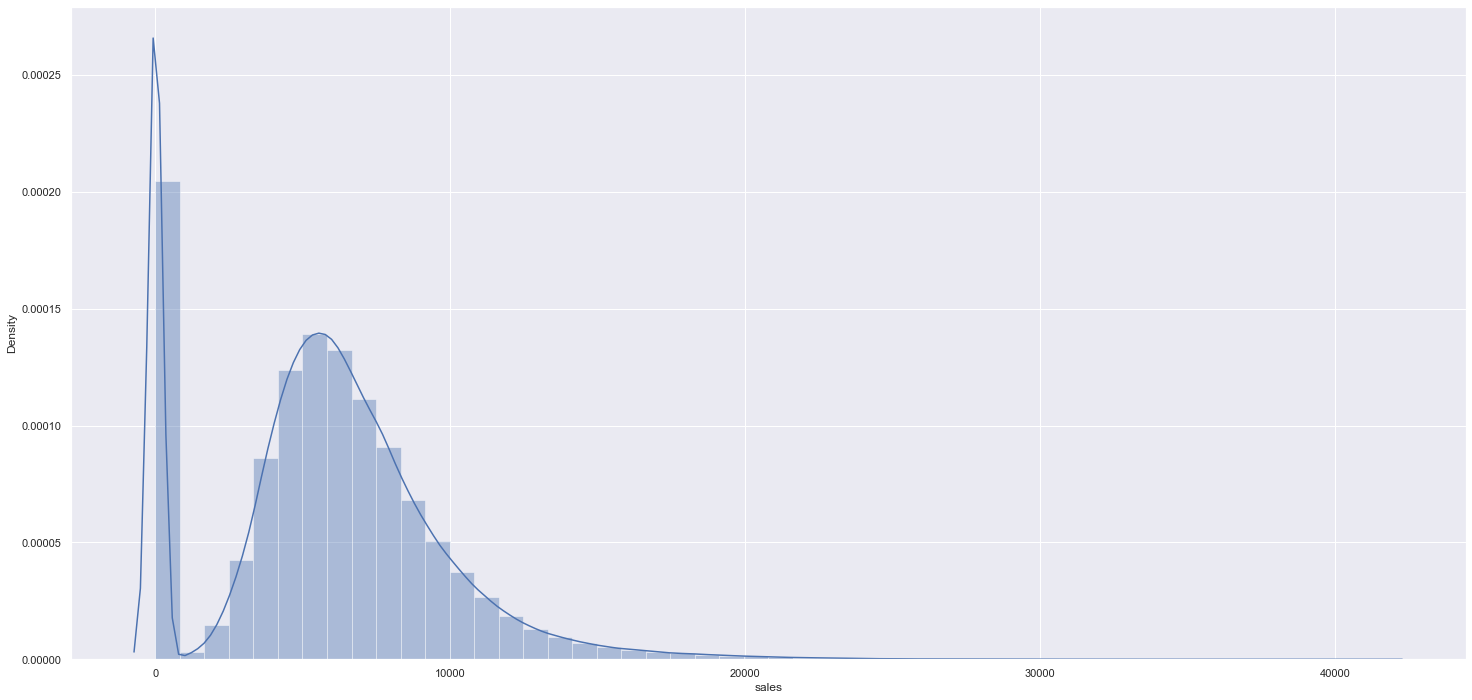

In [15]:
sns.distplot(df1['sales']);

### 1.7.2 Categorical Attributes

In [16]:
categorical_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

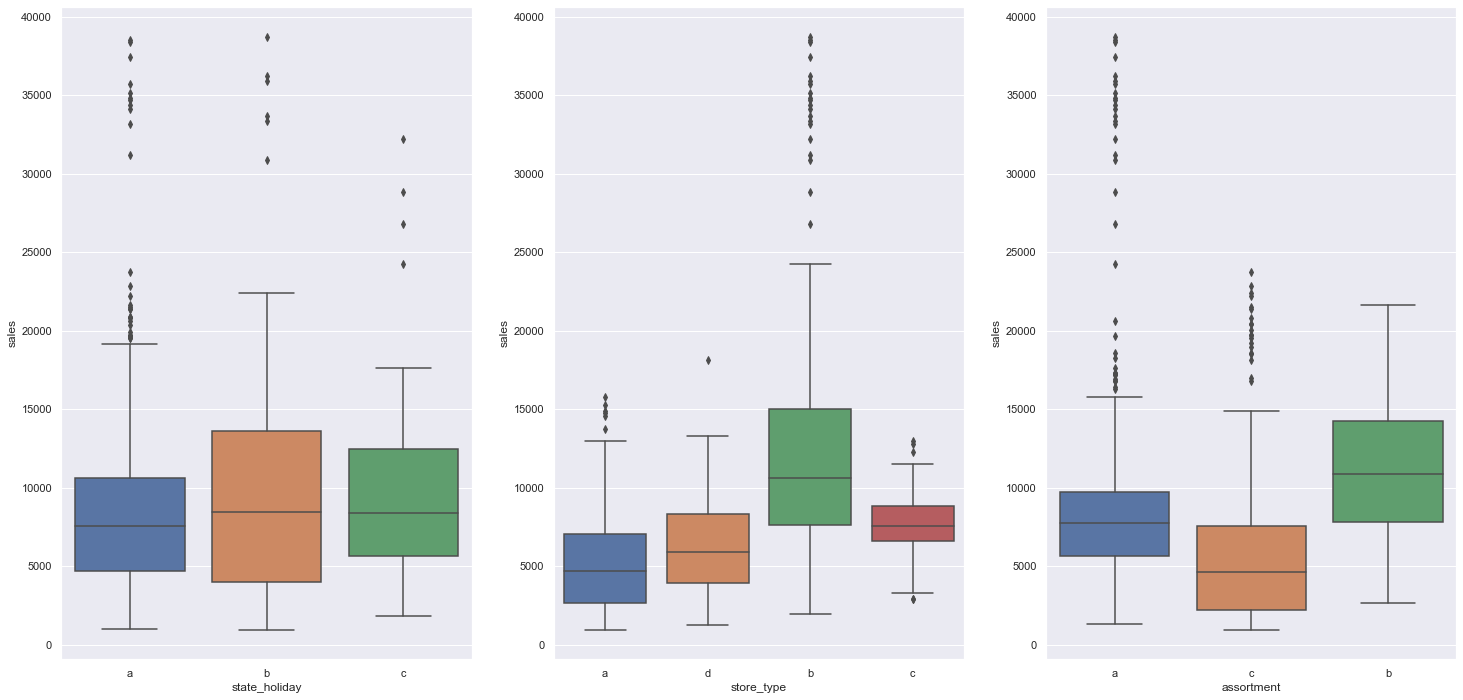

In [17]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux);

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Criação das Hipóteses

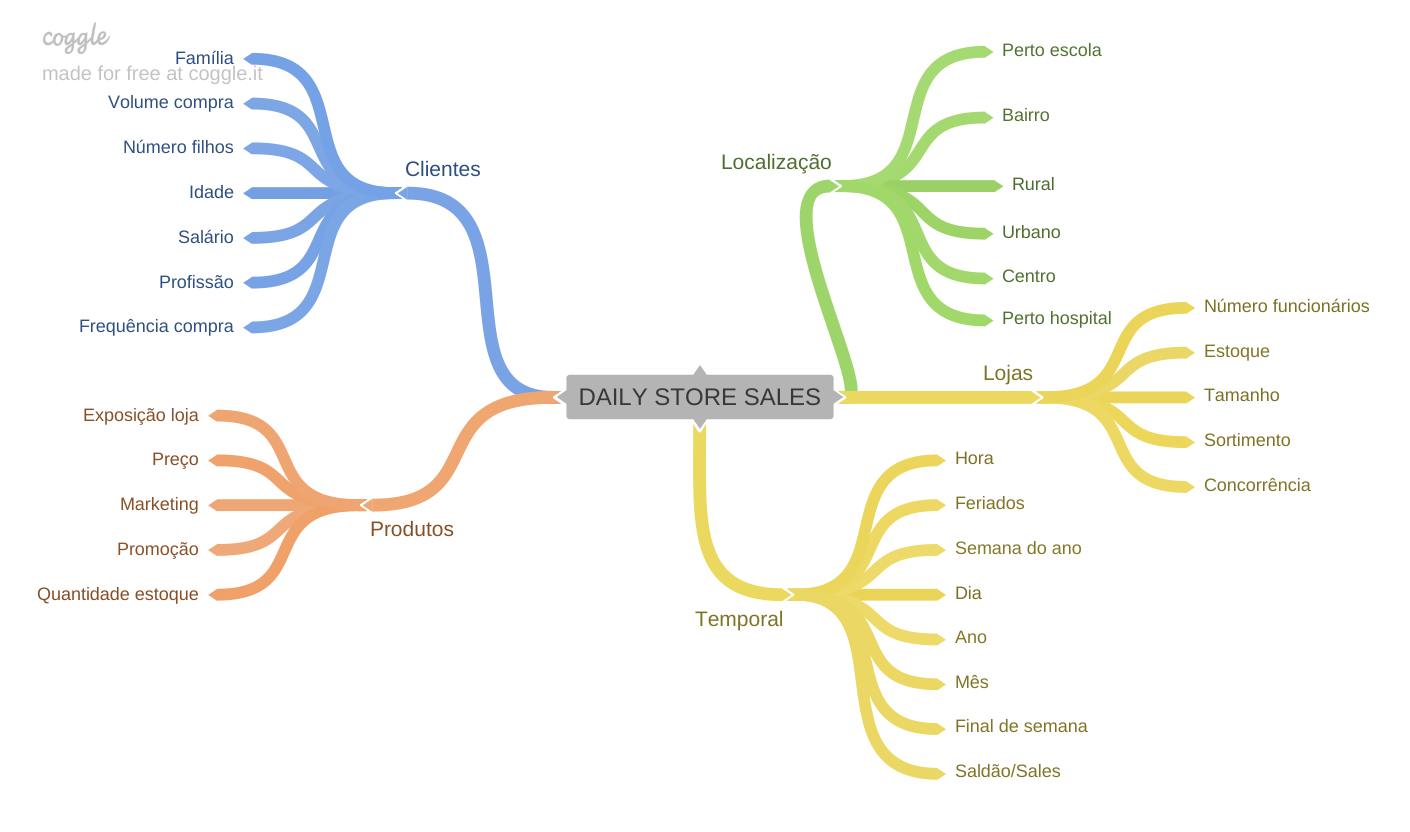

In [19]:
Image('../img/DAILY_STORE_SALES.png')

### 2.1.1. Hipóteses Loja

#### 1. Lojas com maior quadro de funcionários deveria vender mais
#### 2. Lojas com maior estoque deveriam vender mais
#### 3. Lojas com maior porte deveriam vender mais
#### 4. Lojas com menor porte deveriam vender menos
#### 5. Lojas com maior sortimento deveriam vender mais

### 2.1.2. Hipóteses Produto

#### 1. Lojas que investem mais em marketing deveriam vender mais
#### 2. Lojas que expõem mais os produtos nas vitrines deveriam vender mais
#### 3. Lojas que tem preços menores deveriam vender mais
#### 4. Lojas que tem preços menores por mais tempo deveriam vender mais
#### 5. Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais
#### 6. Lojas com promoções ativas por mais tempo deveriam vender mais
#### 7. Lojas com mais dias de promoção deveriam vender mais
#### 8. Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3. Hipóteses Tempo

#### 1. Lojas abertas durante o feriado de natal deveriam vender mais
#### 2. Lojas deveriam vender mais ao longo dos anos
#### 3. Lojas deveriam vender mais no segundo semestre
#### 4. Lojas deveriam vender mais depois do dia 10 de cada mês
#### 5. Lojas deveriam vender menos aos finais de semana
#### 6. Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista Final de Hipóteses

### 1. Lojas com maior sortimentos deveriam vender mais.
### 2. Lojas com competidores mais próximos deveriam vender menos.
### 3. Lojas com competidores à mais tempo deveriam vendem mais.
### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
### 5. Lojas com mais dias de promoção deveriam vender mais.
### 7. Lojas com mais promoções consecutivas deveriam vender mais.
### 8. Lojas abertas durante o feriado de Natal deveriam vender mais.
### 9. Lojas deveriam vender mais ao longo dos anos.
### 10. Lojas deveriam vender mais no segundo semestre do ano.
### 11. Lojas deveriam vender mais depois do dia 10 de cada mês.
### 12. Lojas deveriam vender menos aos finais de semana.
### 13. Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [20]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.weekofyear

# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

In [21]:
# competition since
df2["competition_since"] = df2.apply(
    lambda x: datetime.datetime(
        year = x["competition_open_since_year"],
        month = x["competition_open_since_month"],
        day = 1,
    ),
    axis=1,
)

df2["competition_time_month"] = (
    ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)
)

# promo since
df2["promo_since"] = (
    df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
)
df2["promo_since"] = df2["promo_since"].apply(
    lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w")
    - datetime.timedelta(days=7)
)
df2["promo_time_week"] = (
    ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)
)

# assortment
df2["assortment"] = df2["assortment"].apply(
    lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended"
)

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(
    lambda x: "public_holiday"
    if x == "a"
    else "easter_holiday"
    if x == "b"
    else "christmas"
    if x == "c"
    else "regular_day"
)

In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [23]:
df3 = df2.copy()

## 3.1. Filtragem de linhas

In [24]:
# Apagar as linhas não utilizadas
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0) ] 

## 3.2. Filtragem de colunas

In [25]:
# Apagar as colunas não utilizadas
drop_col = ['open', 'customers', 'promo_interval', 'month_map']
df3.drop(drop_col, inplace=True, axis=1)

# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [26]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

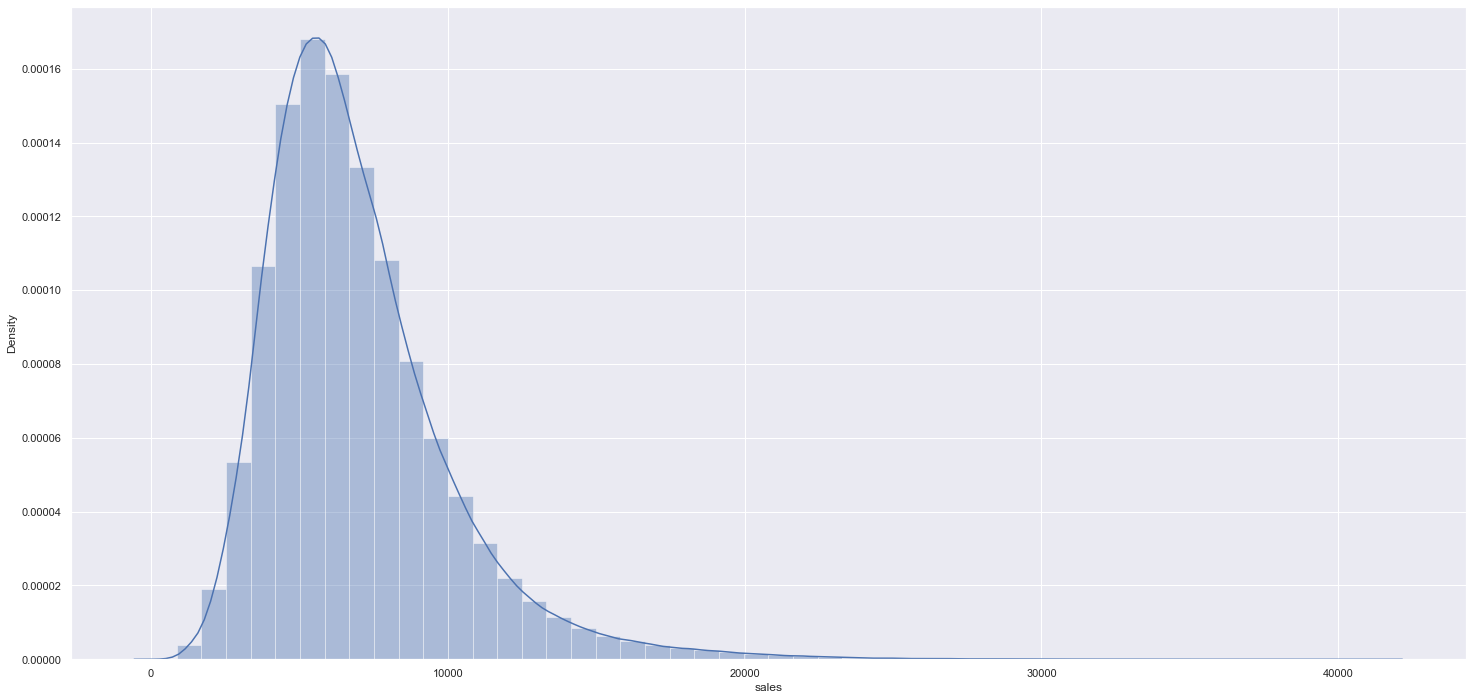

In [27]:
sns.distplot(df4['sales'], kde=True);

### 4.1.2. Variáveis Numéricas

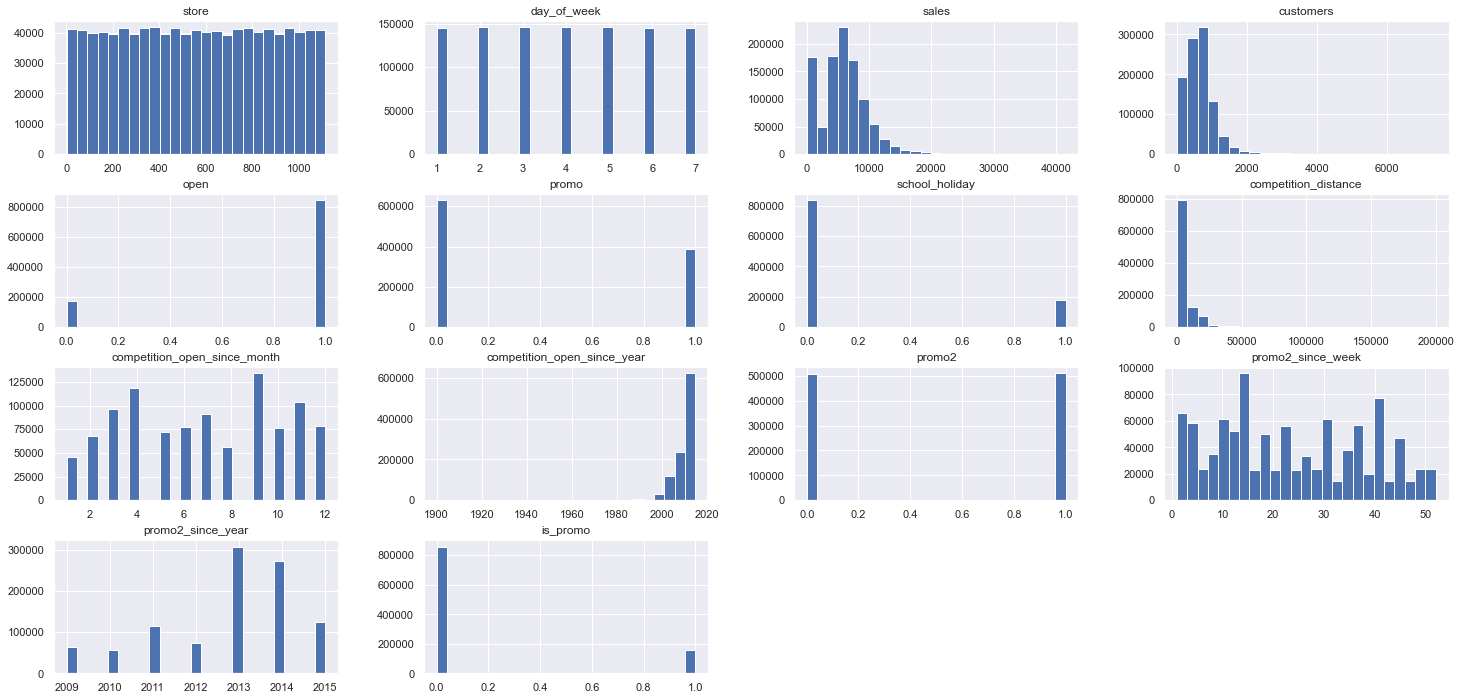

In [28]:
numerical_attributes.hist(bins=25);

### 4.1.3. Variáveis Categóricas

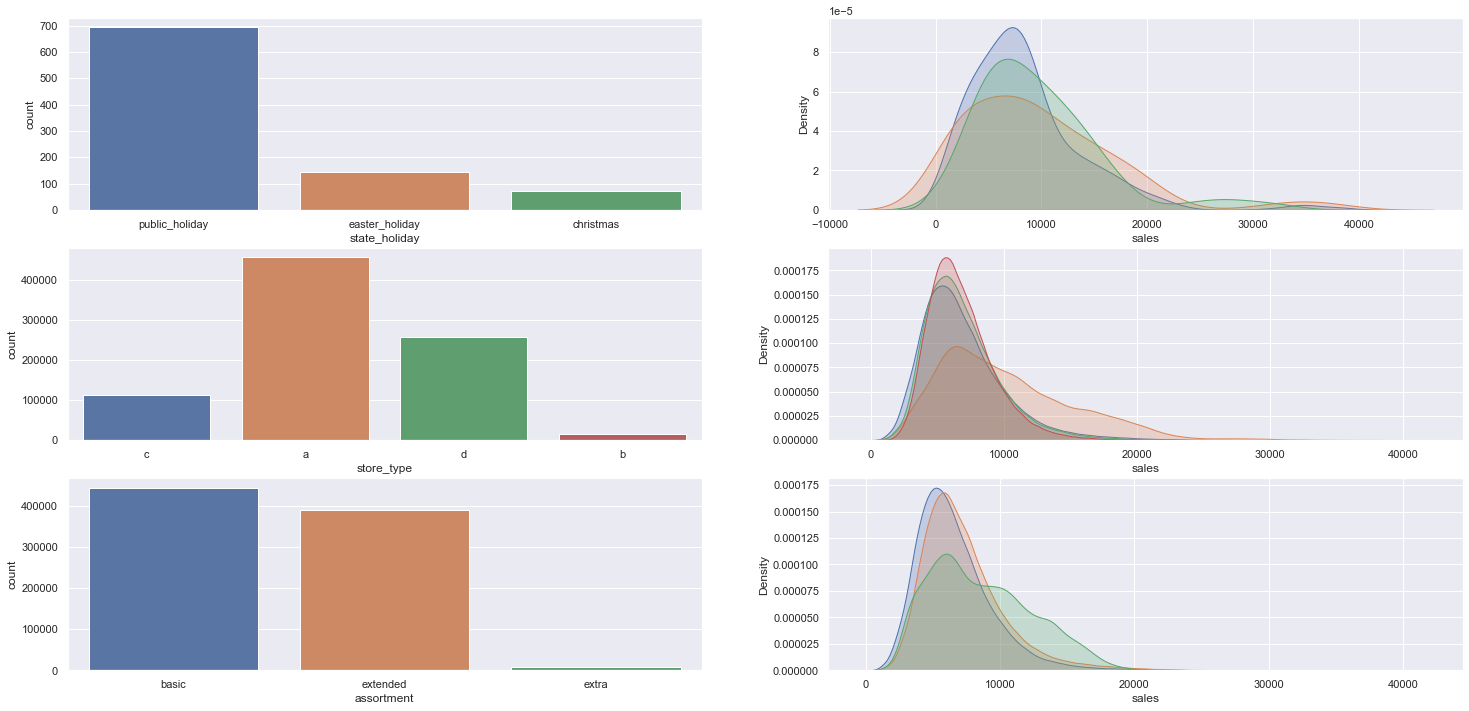

In [29]:
# Plotando as variáveis categóricas
plt.subplot(3, 2, 1)
a = (df4[df4['state_holiday'] != 'regular_day']);
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(a[a['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(a[a['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(a[a['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Análise Bivariada

### <b>H1. Lojas com MAIOR SORTIMENTO deveriam vender MAIS</b>
### ***Hipótese falsa*** - Lojas com MAIOR SORTIMENTO vendem MENOS

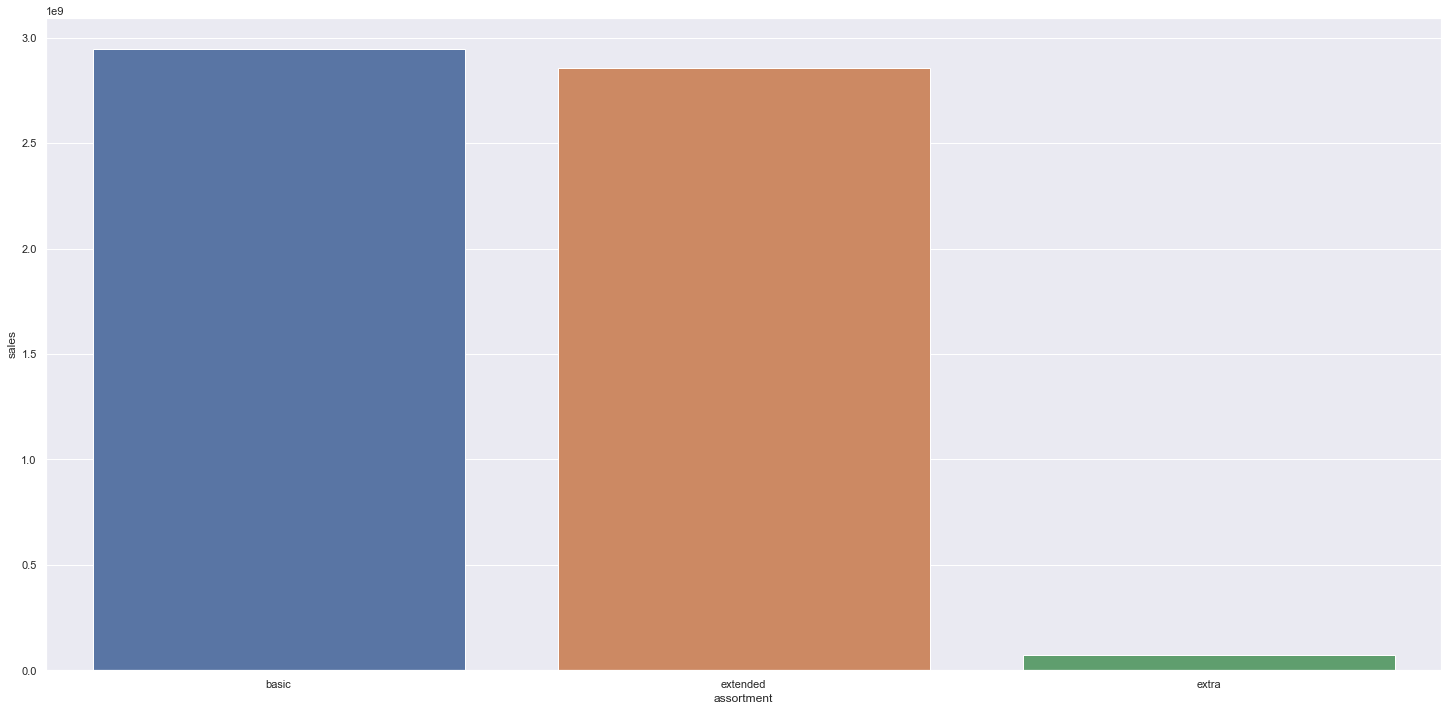

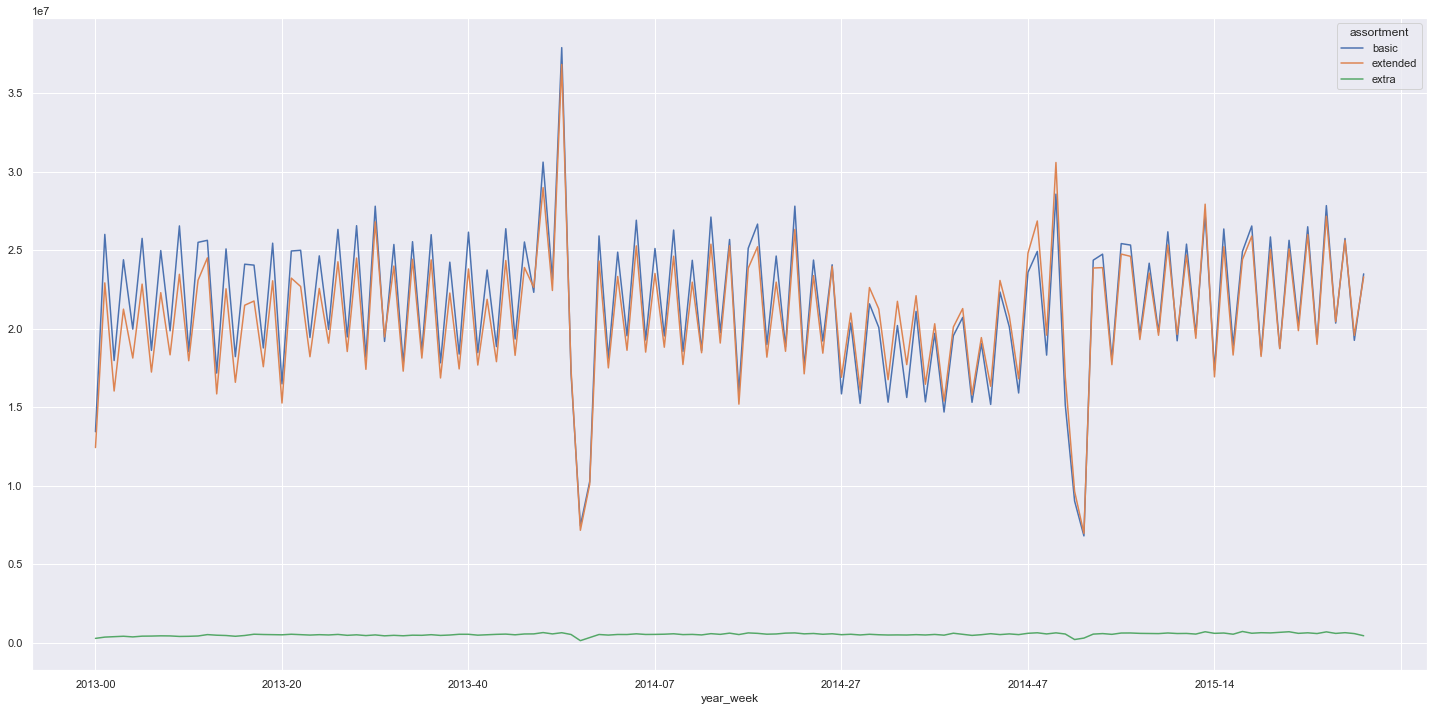

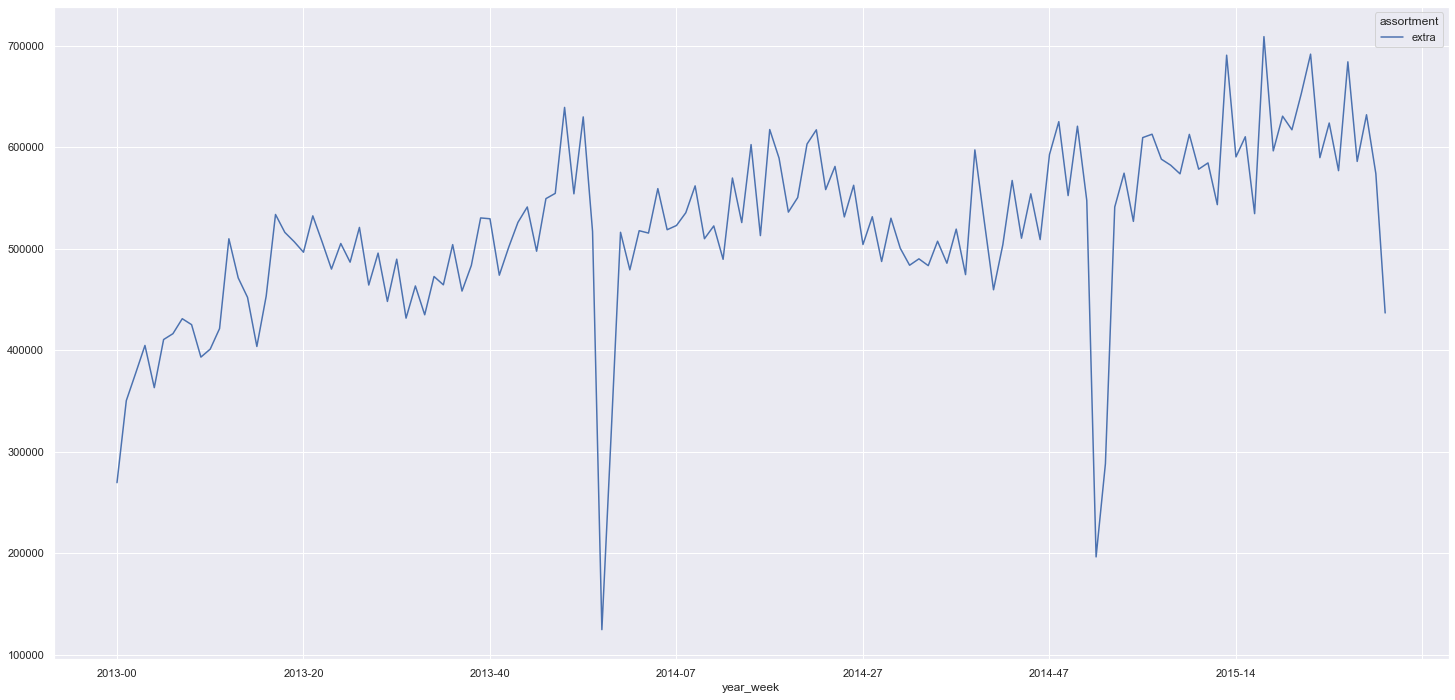

In [30]:
# Quantidade de vendas por tipo de assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Quantidade de vendas por assortment por semanas do ano
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales')
aux3.plot();

# Plotagem somente do tipo 'extra' de assortment
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index='year_week', columns='assortment', values='sales').plot();

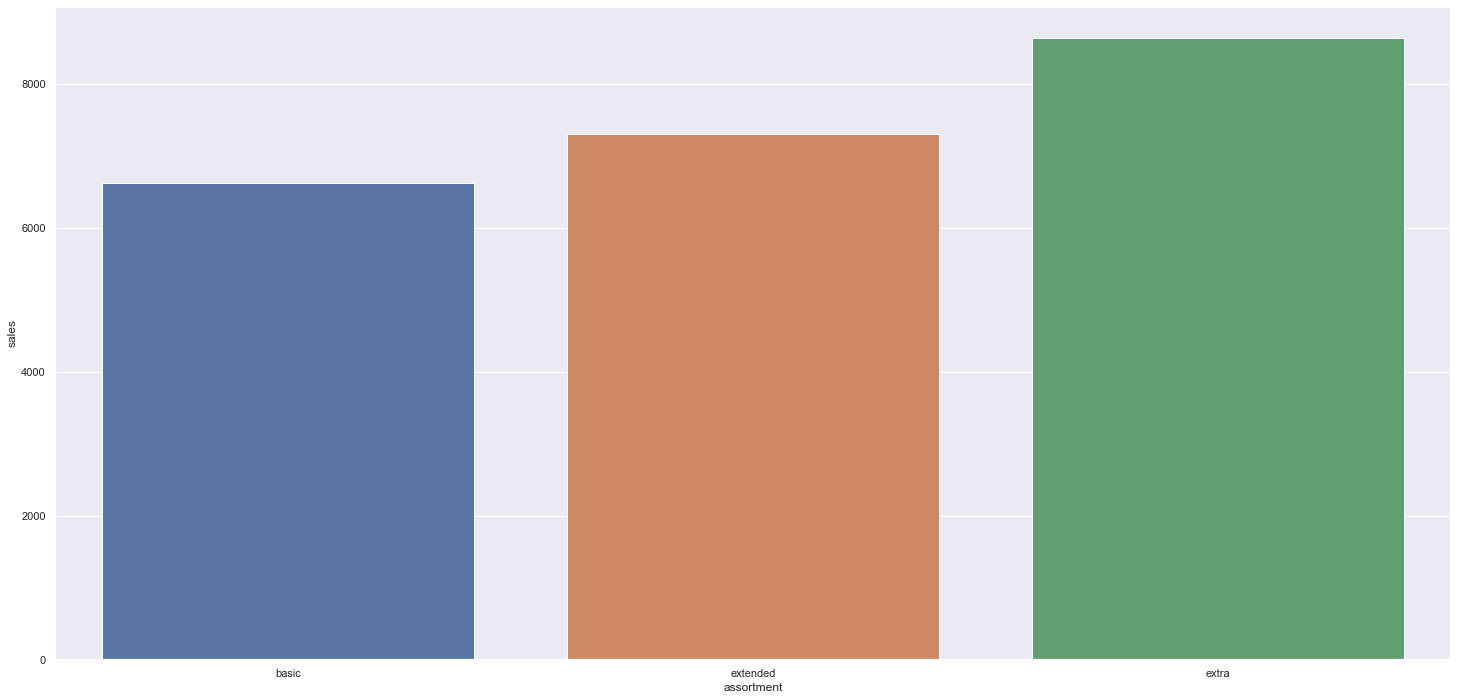

In [31]:
# Quantidade de vendas média por tipo de assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

### <b>H2. Lojas com competidores próximos deveriam vender menos</b>
### ***HIPÓTESE FALSA*** - Lojas com COMPETIDORES PRÓXIMOS vendem MAIS

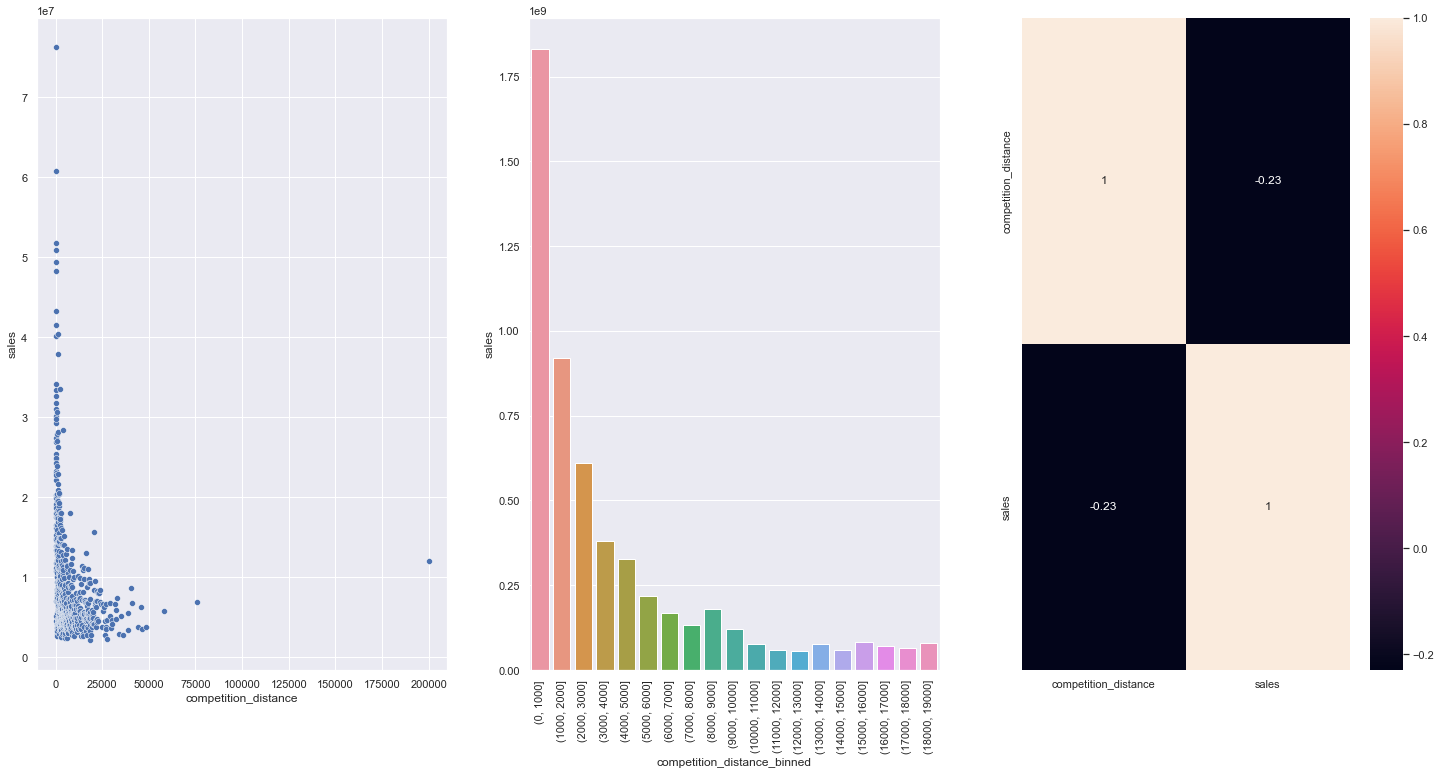

In [32]:
# Plotando as vendas por distancia da loja para concorrência

plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(data=aux1, x='competition_distance', y='sales');

plt.subplot(1, 3, 2)
# Criando os bins (níveis para o gráfico)
bins = np.arange(0, 20000, 1000)
# 'Cortando' a coluna nos tamenhos dos bins
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales',);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores a mais tempo deveriam vender mais
### ***HIPÓTESE FALSA*** - Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

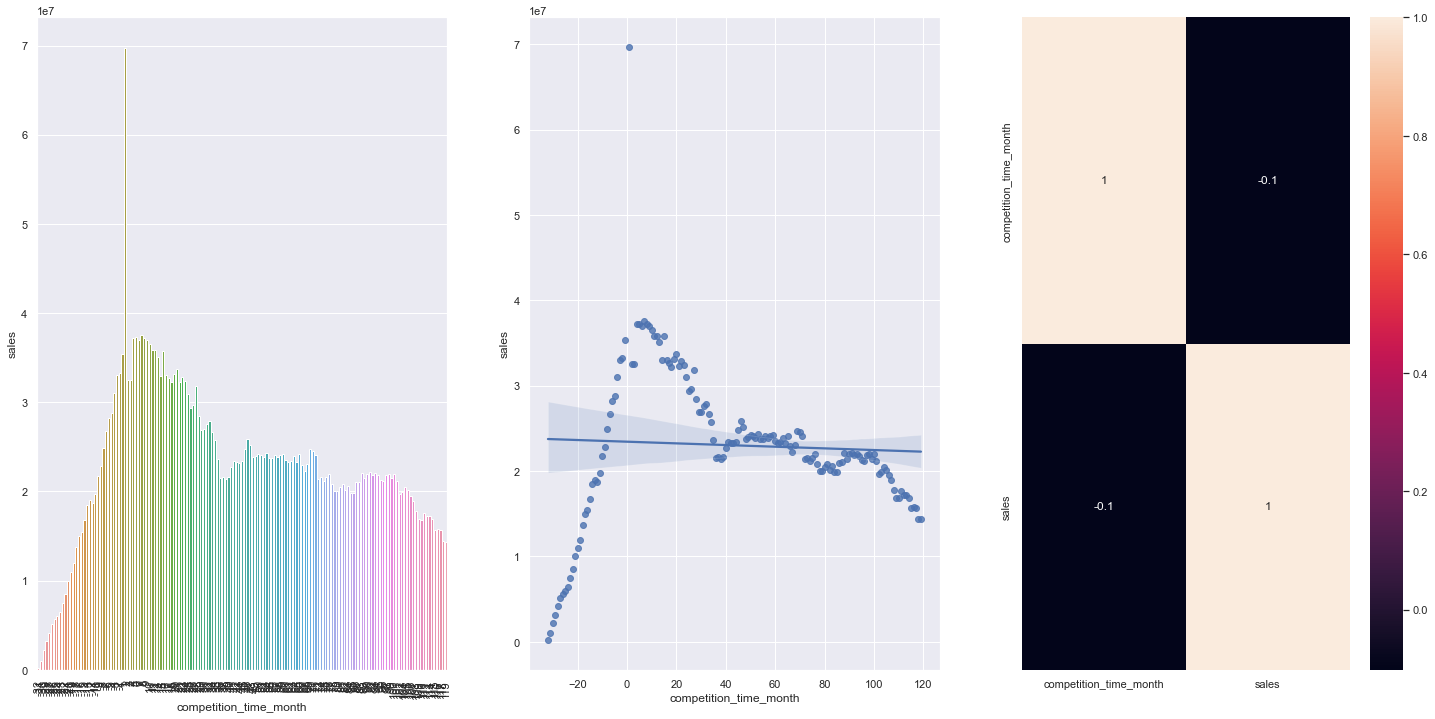

In [33]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
### ***HIPÓTESE FALSA*** - Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

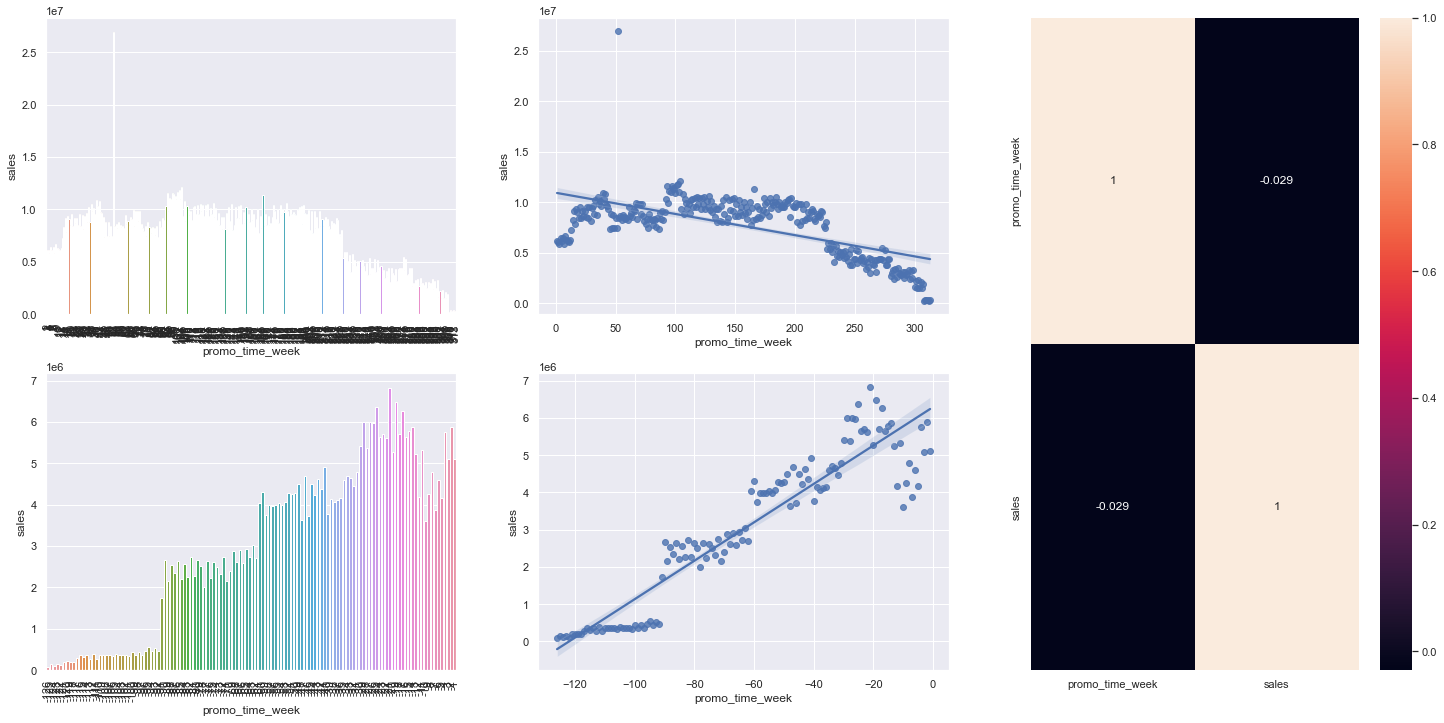

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H5. Lojas com mais dias de promoção deveriam vender mais
### ***HIPÓTESE ?*** - Lojas com mais dias de promoção ??

### H7. Lojas com mais promoções consecutivas deveriam vender mais
### ***HIPÓTESE FALSA*** - Lojas com mais promocoes consecutivas vendem menos

In [35]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


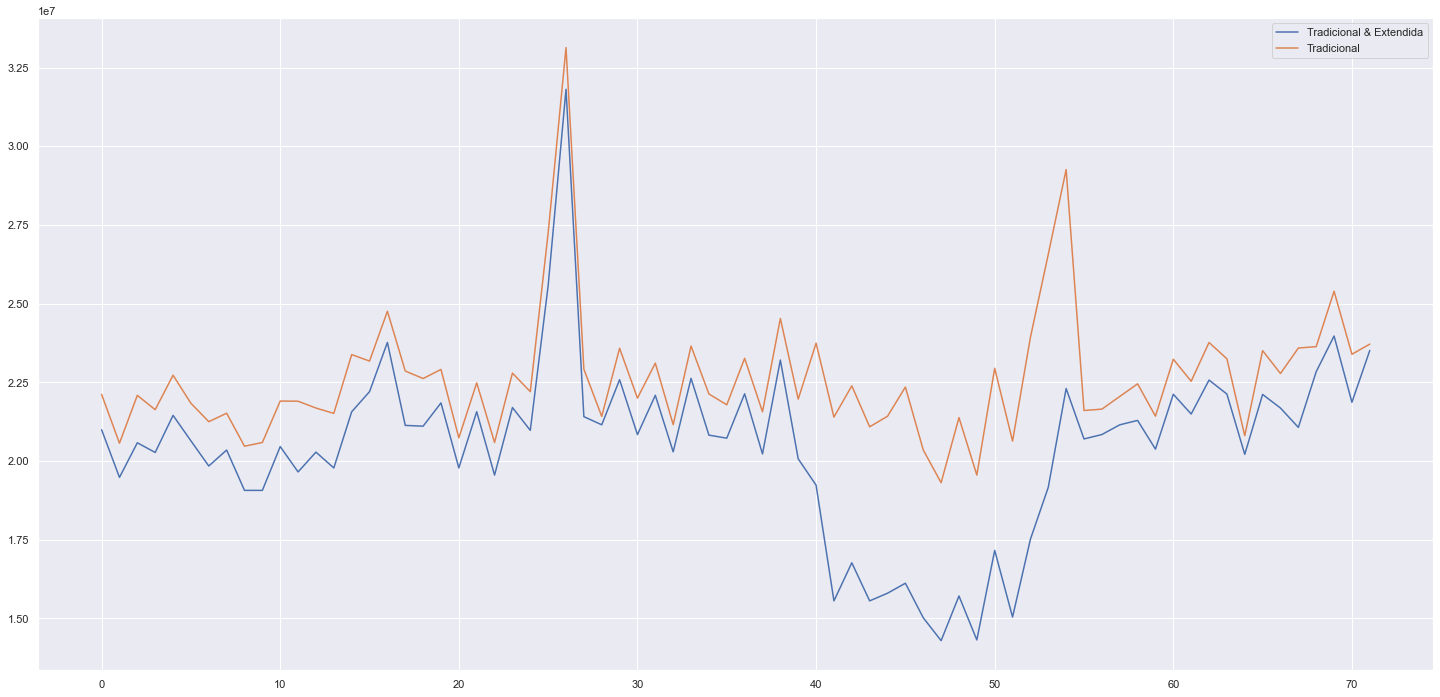

In [36]:
aux1 = (
    df4[(df4["promo"] == 1) & (df4["promo2"] == 1)][["year_week", "sales"]]
    .groupby("year_week")
    .sum()
    .reset_index()
)
ax = aux1.plot();

aux2 = (
    df4[(df4["promo"] == 1) & (df4["promo2"] == 0)][["year_week", "sales"]]
    .groupby("year_week")
    .sum()
    .reset_index()
)
aux2.plot(ax=ax);

ax.legend(labels=["Tradicional & Extendida", "Tradicional"]);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
### ***HIPÓTESE FALSA*** - Lojas abertas durante o feriado do Natal vendem menos.

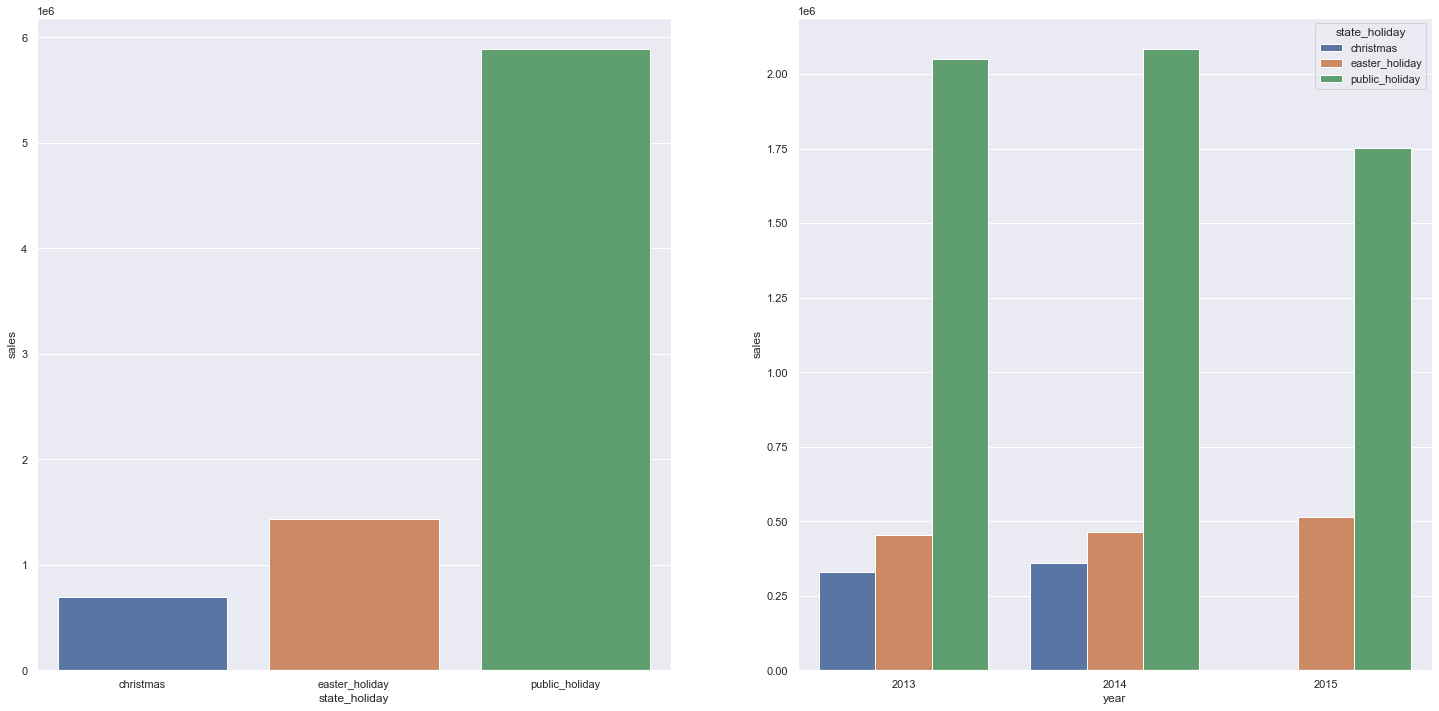

In [37]:
aux = df4[df4["state_holiday"] != "regular_day"]

plt.subplot(1, 2, 1)
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);

plt.subplot(1, 2, 2)
aux2 = (
    aux[["year", "state_holiday", "sales"]]
    .groupby(["year", "state_holiday"])
    .sum()
    .reset_index()
)
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);

### H9. Lojas deveriam vender mais ao longo dos anos.
### ***HIPÓTESE FALSA*** - Lojas vendem menos ao longo dos anos.

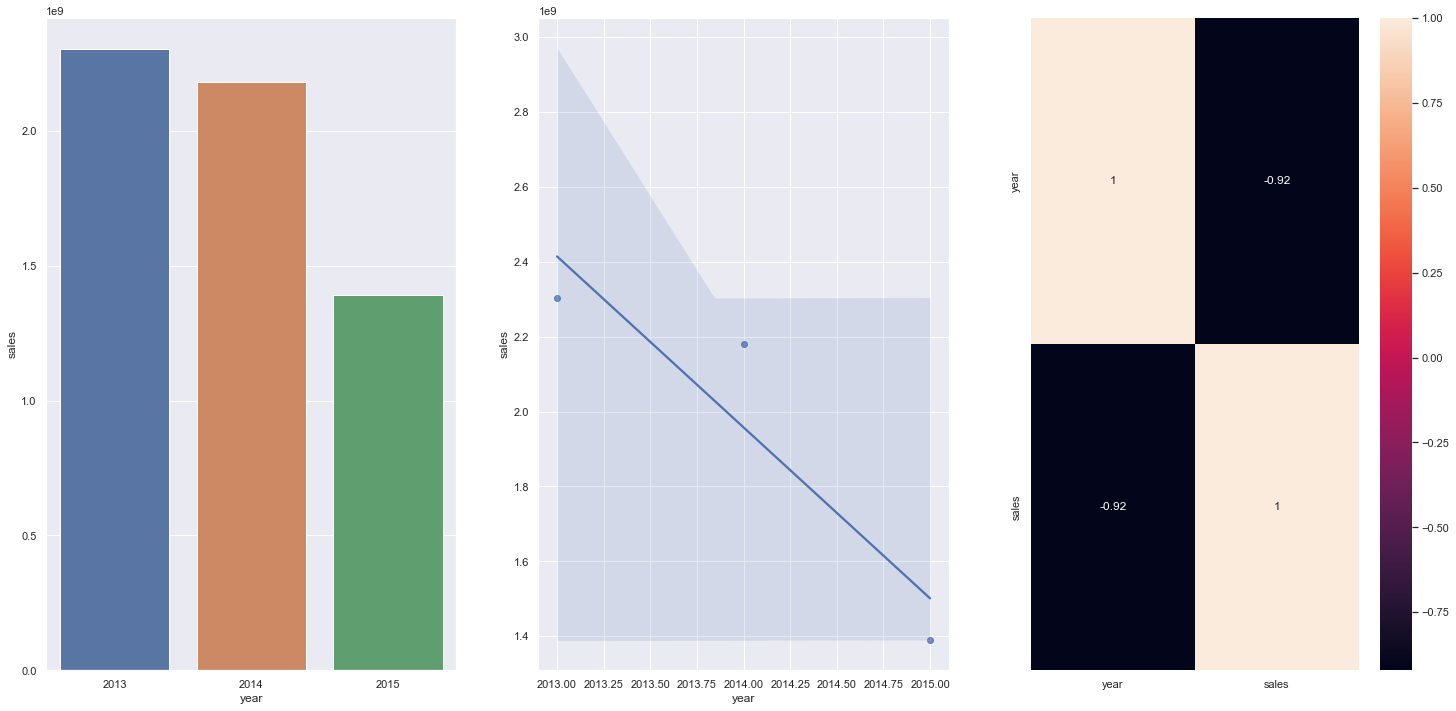

In [38]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais no segundo semestre do ano.
### ***HIPÓTESE FALSA*** - Lojas vendem menos no segundo semestre do ano.

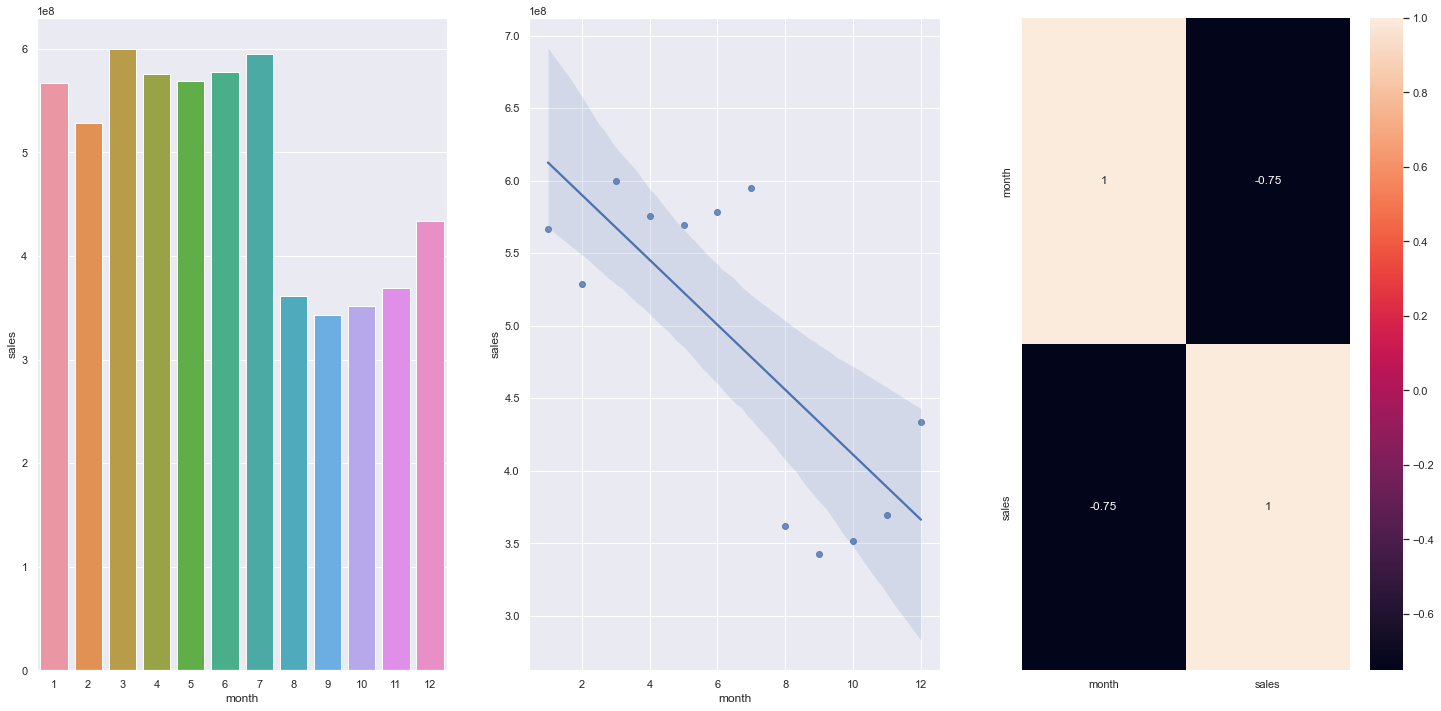

In [39]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
### ***HIPÓTESE VERDADEIRA*** - Lojas vendem mais depois do dia 10 de cada mes

<AxesSubplot:xlabel='before_after', ylabel='sales'>

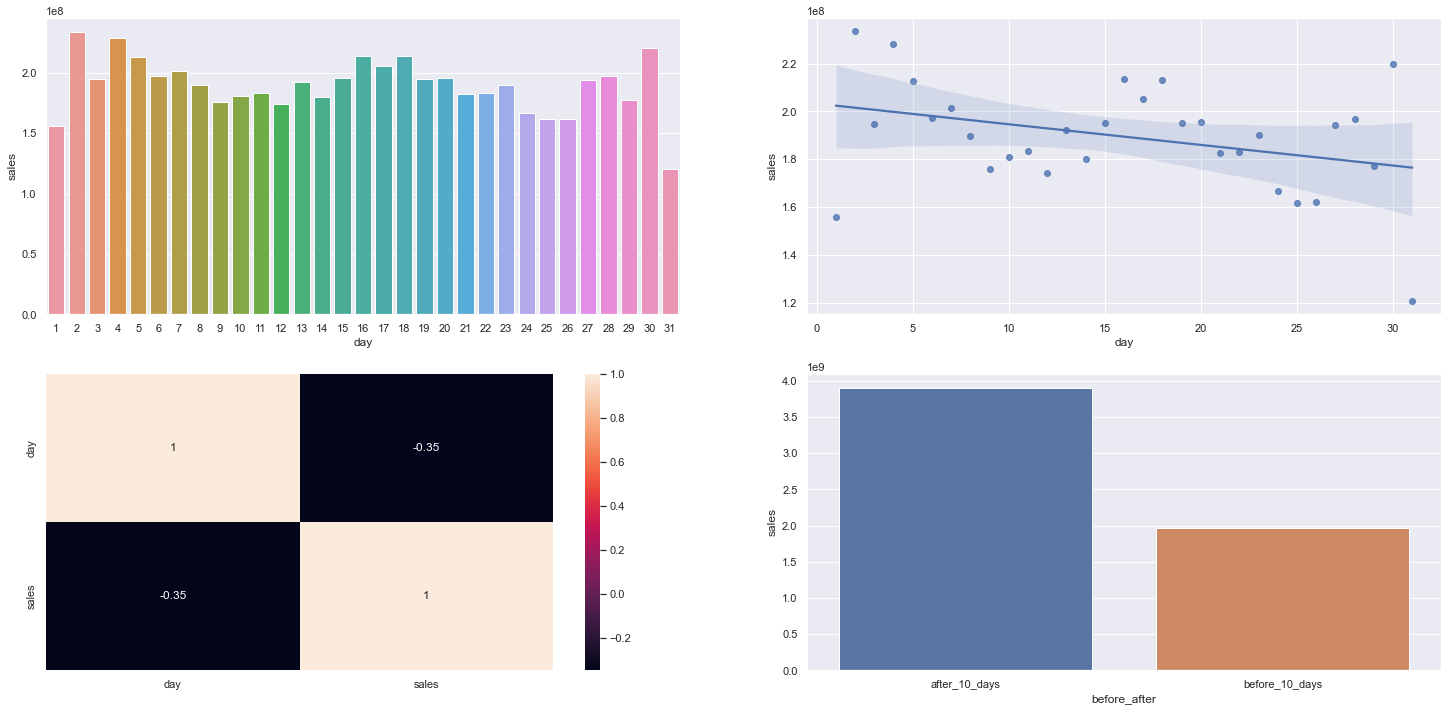

In [40]:
aux1 = df4[["day", "sales"]].groupby("day").sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x="day", y="sales", data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x="day", y="sales", data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

aux1["before_after"] = aux1["day"].apply(
    lambda x: "before_10_days" if x <= 10 else "after_10_days"
)
aux2 = aux1[["before_after", "sales"]].groupby("before_after").sum().reset_index()
plt.subplot(2, 2, 4)
sns.barplot(x="before_after", y="sales", data=aux2)

### H12. Lojas deveriam vender menos aos finais de semana. 
### ***HIPÓTESE VERDADEIRA*** - Lojas vendem menos nos final de semana.

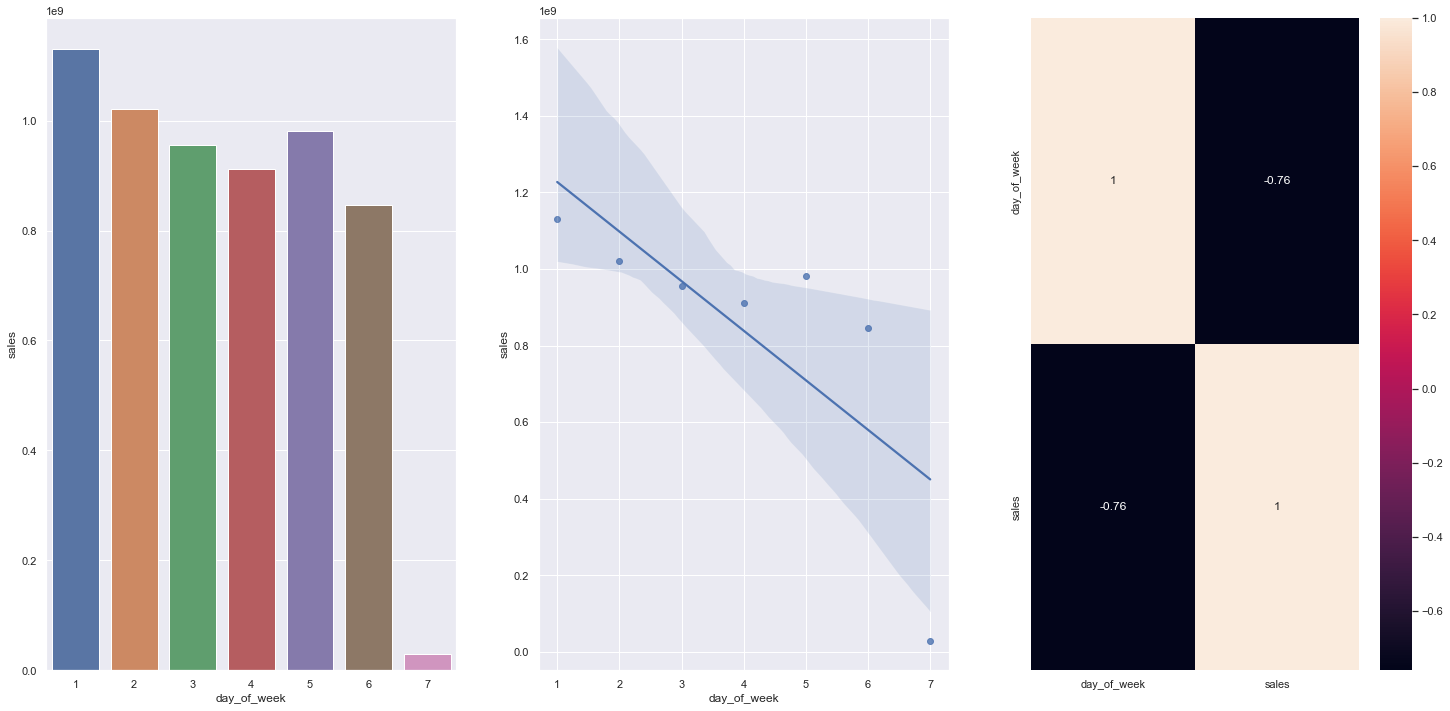

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares.
### ***HIPÓTESE VERDADEIRA*** - Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

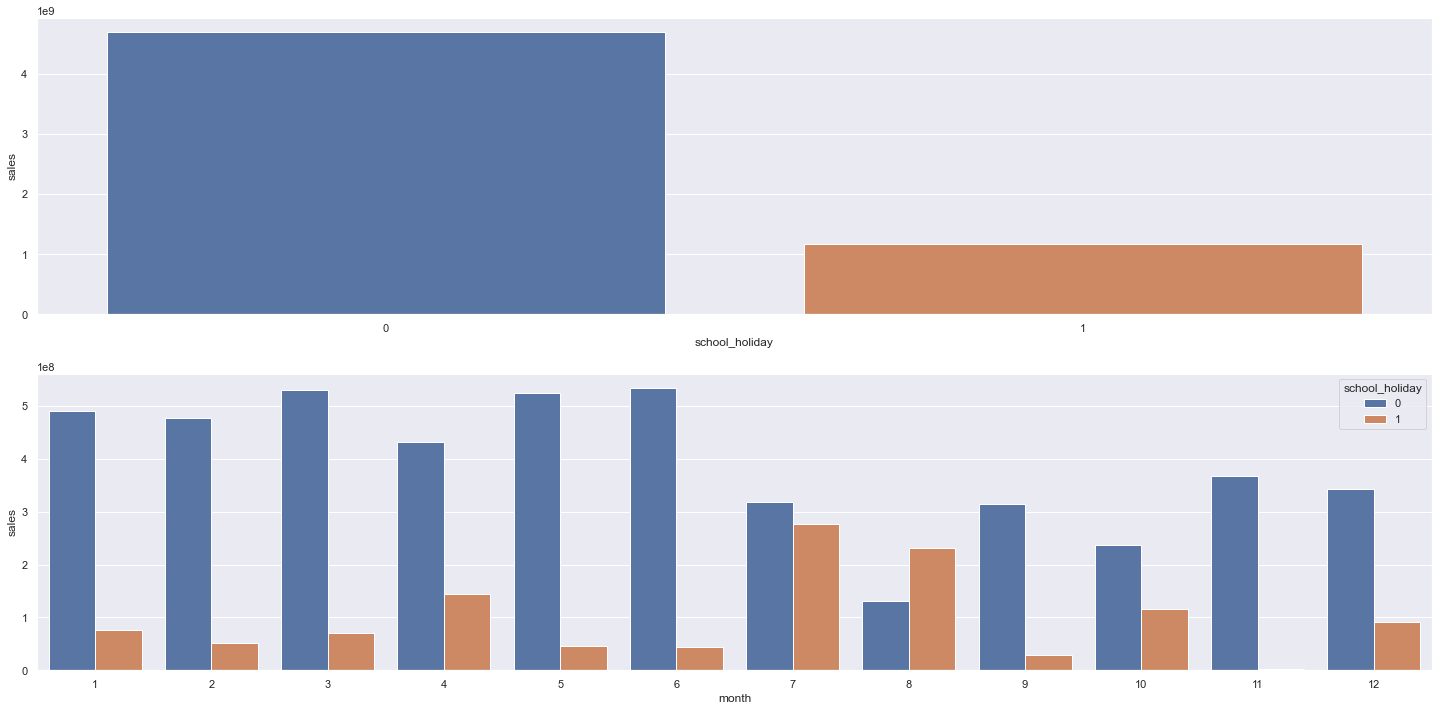

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Resumo das Hipoteses

In [43]:
from tabulate import tabulate

In [44]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

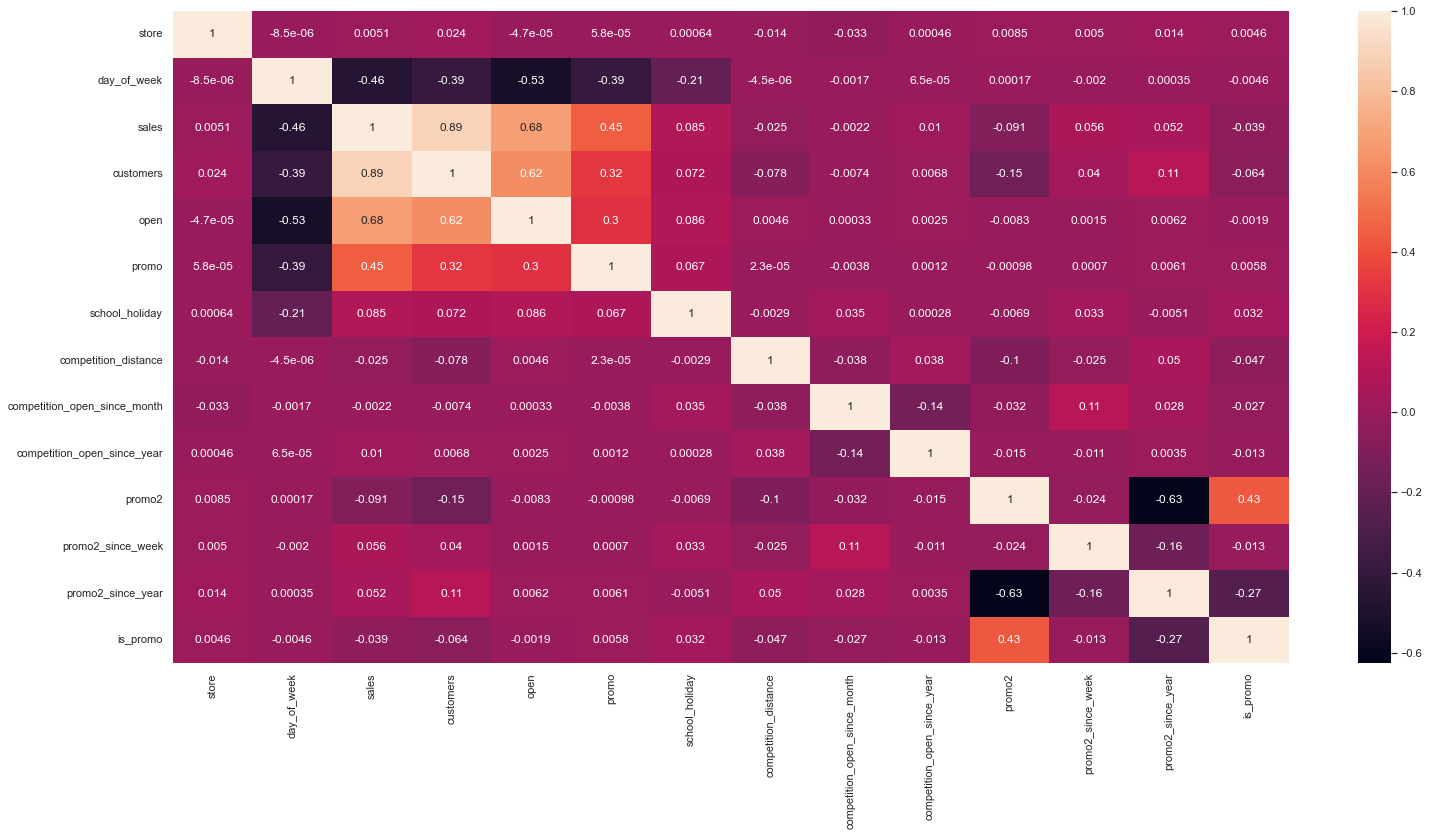

In [45]:
correlation = numerical_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

### ***Cramér's V***
### $ V={\sqrt {{\frac {\varphi ^{2}}{\min(k-1,r-1)}}}}={\sqrt {{\frac {\chi ^{2}/n}{\min(k-1,r-1)}}}} $

### where:

### $ {\displaystyle \varphi } $ is the phi coefficient.

### $ {\displaystyle \chi ^{2}} $ is derived from Pearson's chi-squared test 

### n is the grand total of observations and

### k being the number of columns.

### r being the number of rows. $

### ***Bias correction***

### $ {\displaystyle {\tilde {V}}={\sqrt {\frac {{\tilde {\varphi }}^{2}}{\min({\tilde {k}}-1,{\tilde {r}}-1)}}}} $

### where

### $ {\displaystyle {\tilde {\varphi }}^{2}=\max \left(0,\varphi ^{2}-{\frac {(k-1)(r-1)}{n-1}}\right)}  $

### and

### $ {\displaystyle {\tilde {k}}=k-{\frac {(k-1)^{2}}{n-1}}} $
### $ {\displaystyle {\tilde {r}}=r-{\frac {(r-1)^{2}}{n-1}}} $

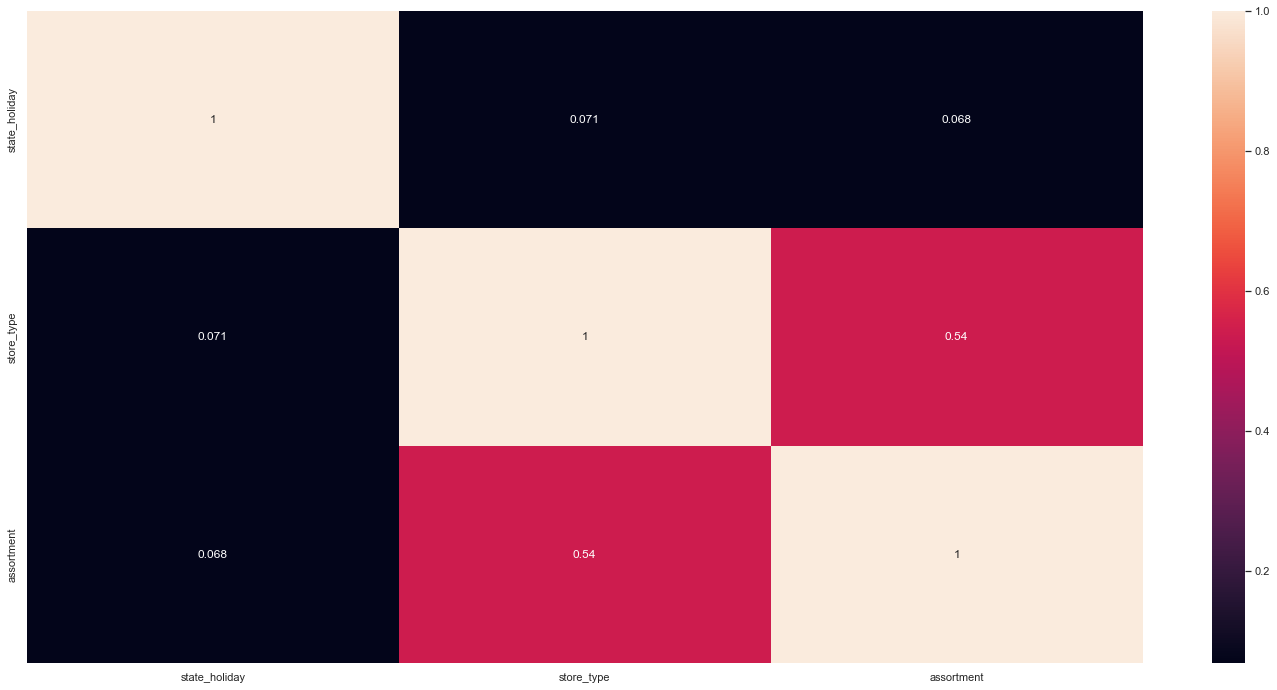

In [46]:
# Pegar atributos categóricos
a = df4.select_dtypes(include=object)

# Calcular Cramér's v
a1 = cramer_v(a["state_holiday"], a["state_holiday"])
a2 = cramer_v(a["state_holiday"], a["store_type"])
a3 = cramer_v(a["state_holiday"], a["assortment"])

a4 = cramer_v(a["store_type"], a["state_holiday"])
a5 = cramer_v(a["store_type"], a["store_type"])
a6 = cramer_v(a["store_type"], a["assortment"])

a7 = cramer_v(a["assortment"], a["state_holiday"])
a8 = cramer_v(a["assortment"], a["store_type"])
a9 = cramer_v(a["assortment"], a["assortment"])

d = pd.DataFrame(
    {
        "state_holiday" : [a1, a2, a3],
        "store_type" : [a4, a5, a6],
        "assortment" : [a7, a8, a9],
    }
)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5.0. PASSO 5 - DATA PREPARATION

In [47]:
df5 = df4.copy()

## 5.1. Normalização

In [48]:
# Não temos variáveis com distribuição normal, logo não será aplicado a normalização
# Lembrando que para variáveis com distribuições não gaussianas aplica-se Rescaling

## 5.2. Rescaling

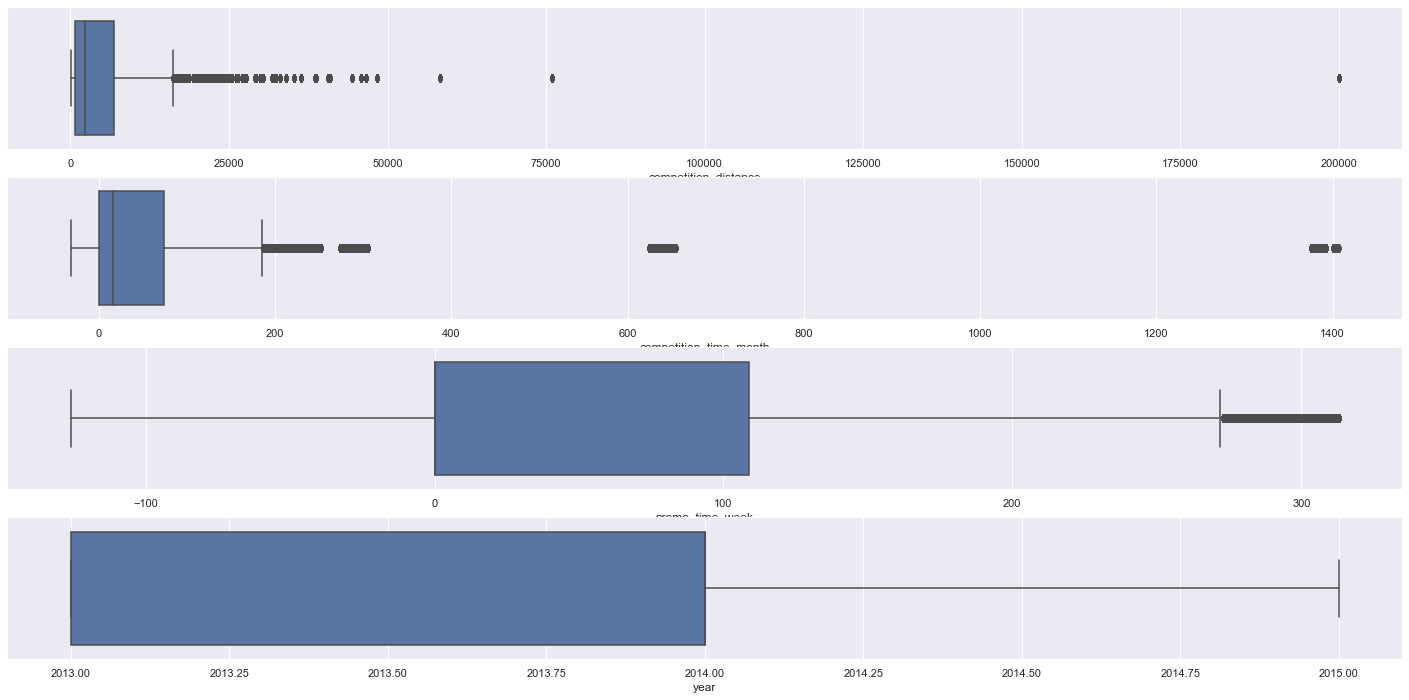

In [49]:
# Verificando se as features possuem muitos outliers

plt.subplot(4, 1, 1)
# competition_distance 
sns.boxplot(df5['competition_distance']);

plt.subplot(4, 1, 2)
# competition_time_month	
sns.boxplot(df5['competition_time_month']);

plt.subplot(4, 1, 3)
# promo_time_week
sns.boxplot(df5['promo_time_week']);

plt.subplot(4, 1, 4)
# year
sns.boxplot(df5['year']);

In [50]:
# Fazendo o rescaling das features
ms = MinMaxScaler() # poucos outliers
rs = RobustScaler() # muitos outliers

# competition_distance 
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month	
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = ms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(ms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = ms.fit_transform(df5[['year']].values)
pickle.dump(ms, open('../parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformação

### <b>5.3.1. Encoding</b>

In [51]:
# state_holiday - Aplicando o One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Aplicando o Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))


# assortment - Aplicando o Ordinal Encoding
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### <b>5.3.2. Response Variable Transformation</b>

In [52]:
# Transformação da variável resposta, que não é gaussiana
df5['sales'] = np.log1p(df5['sales'])

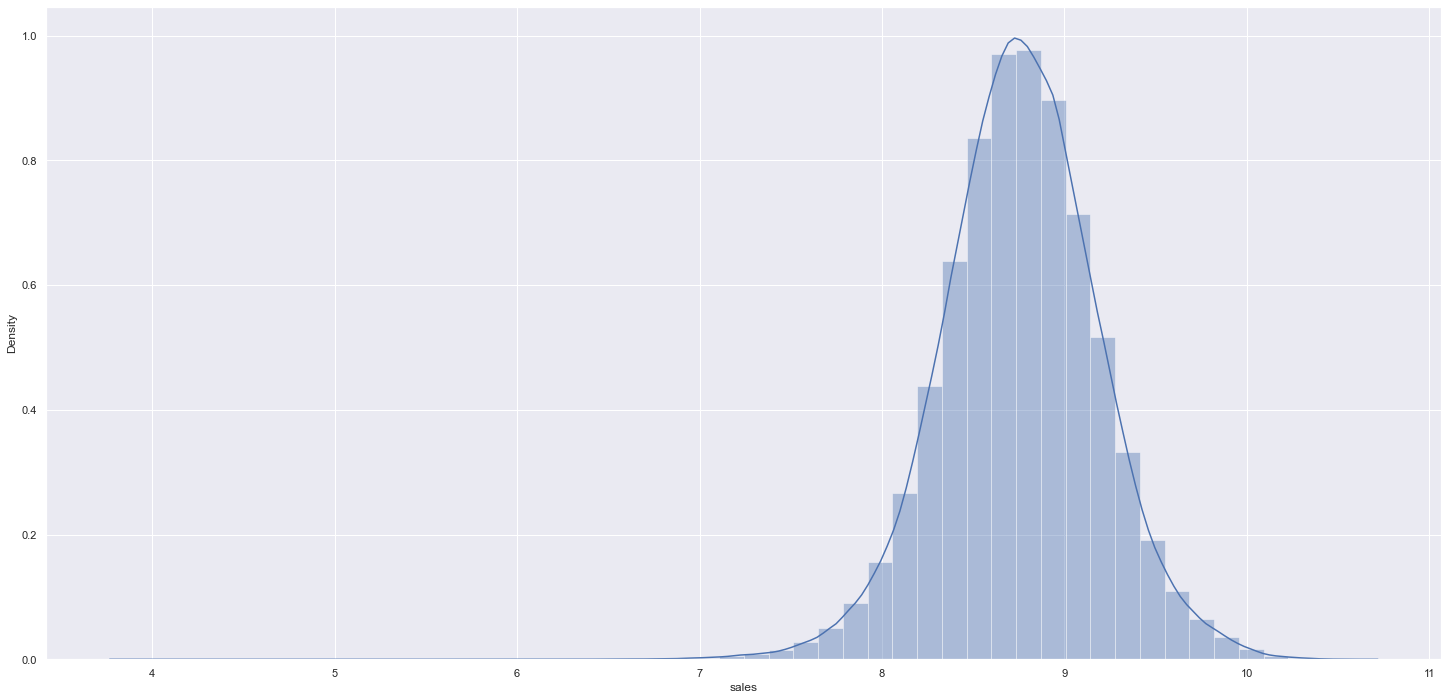

In [53]:
sns.distplot(df5.sales);

### <b>5.3.2. Nature Transformation</b>

In [54]:
# Transformação das features de natureza cíclica

# month	
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi / 12)))
df5['month_cosin'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi / 12)))

# day	
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi / 30)))
df5['day_cosin'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi / 30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi / 52)))
df5['week_of_year_cosin'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi / 52)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi / 7)))
df5['day_of_week_cosin'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi / 7)))

# 6.0. PASSO 6 - FEATURE SELECTION

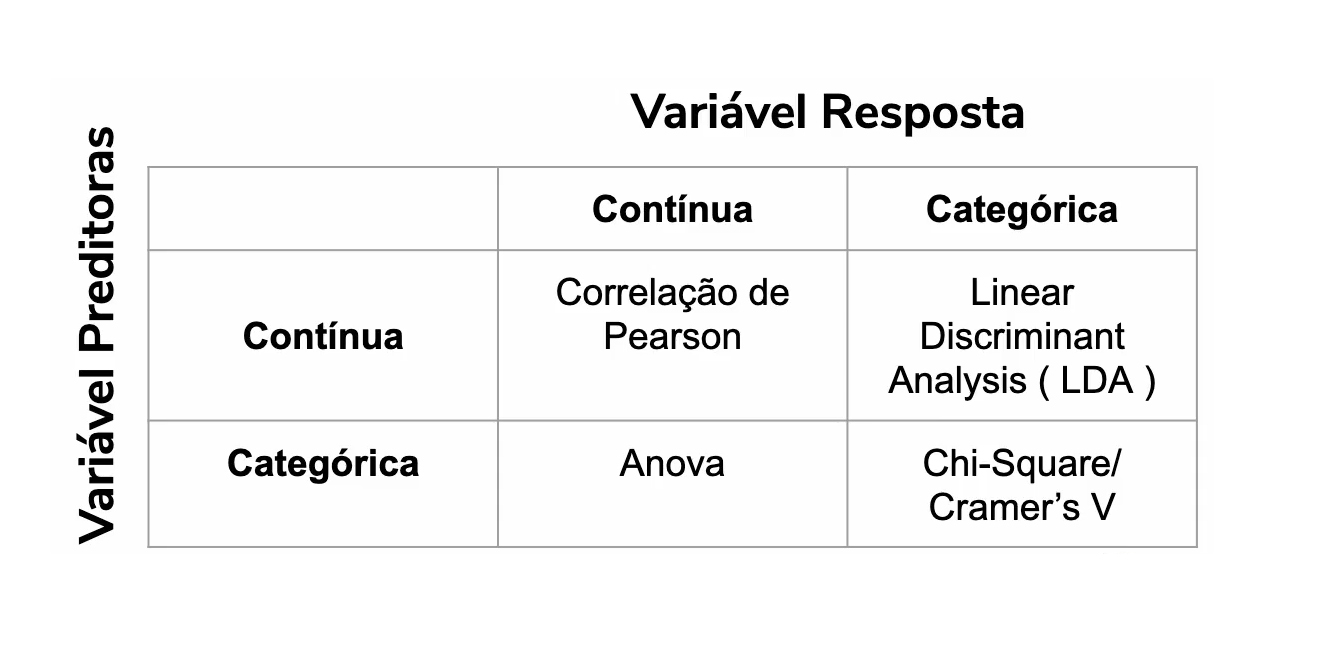

In [55]:
Image( '../img/variable_selection.jpg' )

In [56]:
df6 = df5.copy()

## 6.1. Split Dataframe into training and testing dataset

In [57]:
# Deletar as colunas que derivaram outras e perderam a utilidade
cols_drop = [   'week_of_year', 'day', 'month', 'day_of_week', 
                'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [58]:
# A previsão de vendas será para 6 semanas então as últimas 6 semanas dos dados
# serão usadas para teste do modelo, o restante será usada para treino.
# Subtraindo a 6 semanas da data máxima do dataset encontramos a data limite
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 7 * 6)

Timestamp('2015-06-19 00:00:00')

In [59]:
# Separando o dataset em teste em treino de acordo com a data
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f"Min date train: {X_train['date'].min()}")
print(f"Max date train: {X_train['date'].max()}")

print(f"\nMin date train: {X_test['date'].min()}")
print(f"Max date train: {X_test['date'].max()}")

Min date train: 2013-01-01 00:00:00
Max date train: 2015-06-18 00:00:00

Min date train: 2015-06-19 00:00:00
Max date train: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [60]:
# # O Boruta não recebe como parâmetro um df e sim um numpy.array
# X_train_n = X_train.drop(['sales', 'date'], axis=1).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # Define o Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### **6.2.1. Best Features From Boruta**

In [61]:
# # Armazena os índices das colunas selecionadas e ranqueadas pelo Boruta
# cols_selected = boruta.support_.tolist()

# X_train_fs = X_train.drop(['sales', 'date'], axis=1)
# # Colunas selecionadas pelo Boruta
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Colunas não selecionadas pelo Boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

**Features selecionadas ou não pelo Boruta**
```python
print(cols_selected_boruta)
>>>
['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cosin',
 'day_sin',
 'day_cosin',
 'week_of_year_cosin',
 'day_of_week_sin',
 'day_of_week_cosin']]

 print(cols_not_selected_boruta)
 >>>
 ['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']
 ```

## 6.3. Manual Feature Selection
### **Comparar as sugestões do Boruta com as conclusões das hipóteses e decidir quais entrarão no modelo, lembrando que por ser o CRISP pode utilizar a sugestão do Boruta nessa iteração e na próxima.**

In [62]:
# Célula criada para não ser necessário rodar o Boruta para cada
# iteração do notebook, equivale a seleção manual de features. 
# Foram acrescentadas duas features que o Boruta deixou de fora.
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_sin',
    'month_cosin',
    'day_sin',
    'day_cosin',
    'week_of_year_sin',
    'week_of_year_cosin',
    'day_of_week_sin',
    'day_of_week_cosin']

# columns to add
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cosin',
 'day_sin',
 'day_cosin',
 'week_of_year_sin',
 'week_of_year_cosin',
 'day_of_week_sin',
 'day_of_week_cosin',
 'date',
 'sales']

# 7.0. PASSO 7 - MACHINE LEARNING MODELLING

In [63]:
df7 = df6.copy()

In [64]:
# Criando os datasets de treino e teste com as features selecionadas no passo anterior (Boruta)
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Dataset com as features selecionadas pelo Boruta mais ['date', 'sales']
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [65]:
# Criando o dataset
aux1 = x_test.copy()
aux1["sales"] = y_test.copy()

In [66]:
# Modelo de Média que servirá para comparação

# Prediction
aux2 = (    # Calcula a média para servir de baseline
    aux1[["store", "sales"]]
    .groupby("store")
    .mean()
    .reset_index()
    .rename(columns={"sales": "predictions"})
)
aux1 = pd.merge(aux1, aux2, on="store", how="left")
# Valores de y estimado
yhat_baseline = aux1["predictions"]

# Performance
# Calcula as métricas de erros do modelo de média,  lembrando que é necessário retornar as 
# variáveis para seus valores normais com método exponencial já que foram transformadas com 
# o método logarítmo no passo de transformação
baseline_result = ml_error("Average Model", np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.46,1835.14


## 7.2. Linear Regression Model

In [67]:
# Criando o modelo de Regressão Linear
lr = LinearRegression().fit(x_train, y_train)

# Fazendo a predição
y_hat_lr = lr.predict(x_test)

# Conhecendo a performance do modelo
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(y_hat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


### **7.2.1. Linear Regression Model - Cross Validation**

In [68]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regresion', lr)
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


## 7.3. Linear Regression Regularized Model

In [69]:
# Criando o modelo de Regressão Linear Regularizada
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Fazendo a predição
y_hat_lrr = lrr.predict(x_test)

# Conhecendo a performance do modelo
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(y_hat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1891.70,0.29,2744.45


### **7.3.1. Lasso - Cross Validation**

In [70]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,MODEL NAME,MAE,MAPE,RMSE
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [71]:
# Criando o modelo de Árvore de decisão
# n_estimators=100 -> nº árvores, n_jobs=-1 -> processamento paralelo, random_state=42 -> seed
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Fazendo a predição
y_hat_rf = rf.predict(x_test)

# Conhecendo a performance do modelo
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(y_hat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.69,0.10,1010.61


### **7.4.1. Random Forest - Cross Validation**

In [72]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf)
rf_result_cv

,MODEL NAME,MAE,MAPE,RMSE
0,Random Forest,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73


## 7.5. XGBoost Regressor

In [73]:
# Criando o modelo XGBoost
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    # eta=0.03,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9).fit(x_train, y_train)

# Fazendo a predição
y_hat_xgb = model_xgb.predict(x_test)

# Conhecendo a performance do modelo
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(y_hat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,687.46,0.10,997.97


### **7.5.1. XGBoost - Cross Validation**

In [74]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
# xgb_result_cv

## 7.6. Compare Model's Perfomance

### ***7.6.1. Single Performance***

In [75]:
# Comparando as perfomances dos modelos
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,687.46,0.10,997.97
0,Random Forest,679.69,0.10,1010.61
0,Average Model,1354.80,0.46,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression Regularized,1891.70,0.29,2744.45


### ***7.6.2. Real Performance - Cross Validation***

In [77]:
# # Comparando as perfomances dos modelos
# modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modeling_result_cv.sort_values('RMSE')

# 8.0. PASSO 8 - HIPERPARAMETER FINE TUNNING

## 8.1. Random Search


In [78]:
# Hiperparâmetros do modelo XGBoost com os valores que serão testados
param = {
    'n_estimators' : [1500, 1700, 2500, 3000, 3500],
    'eta' : [0.001, 0.01, 0.03],
    'max_depth' : [3, 5, 9],
    'subsample' : [0.1, 0.5, 0.7],
    'colsample_bytree' : [0.3, 0.7, 0.9],
    'min_child_weight' : [3, 8, 15],
}

MAX_EVAL = 10

In [79]:
# final_result = pd.DataFrame()

# # Quantidade de iterações no teste de parâmetros
# for i in range(MAX_EVAL):
#     # Escolhendo valores aleatórios para os parâmetros
#     hiper = {k : random.sample(v, 1)[0] for k, v in param.items()}
#     print(hiper)

#     # Model
#     model_xgb = xgb.XGBRegressor( 
#         objective = 'reg:squarederror',
#         n_estimators = hiper['n_estimators'],
#         eta = hiper['eta'],
#         max_depth = hiper['max_depth'],
#         subsample = hiper['subsample'],
#         colsample_bytree = hiper['colsample_bytree'],
#         min_child_weight = hiper['min_child_weight'])

#     # Performance
#     result = cross_validation(x_training, 5, 'XGBoost', model_xgb)
#     final_result =  pd.concat([final_result, result])

# final_result

## 8.2. Final Model

In [80]:
# Melhores valores selecionados pelo método de tuning Random Search
param_tuned = {
    'n_estimators' : 3500,
    'eta' : 0.03,
    'max_depth' : 9,
    'subsample' : 0.5,
    'colsample_bytree' : 0.7,
    'min_child_weight' : 15,
}

In [81]:
# Model
model_xgb_tuned = xgb.XGBRegressor( 
    objective = 'reg:squarederror',
    n_estimators = param_tuned['n_estimators'],
    eta = param_tuned['eta'],
    max_depth = param_tuned['max_depth'],
    subsample = param_tuned['subsample'],
    colsample_bytree = param_tuned['colsample_bytree'],
    min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# Predição
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost,622.61,0.09,910.27


In [82]:
# Verificação se o modelo está superestimando (MPE positivo) ou 
# subestimando (MPE negativo)
MPE = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
MPE

0.00936580700669639

# 9.0. PASSO 9 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [83]:
df9 = X_test[cols_selected_boruta_full]

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [84]:
# Soma das predições
df91 = df9[["store", "predictions"]].groupby("store").sum().reset_index()

# MAE e MAPE
df9_aux1 = (
    df9[["store", "sales", "predictions"]]
    .groupby("store")
    .apply(lambda x: mean_absolute_error(x["sales"], x["predictions"]))
    .reset_index()
    .rename({0: "MAE"}, axis=1)
)

df9_aux2 = (
    df9[["store", "sales", "predictions"]]
    .groupby("store")
    .apply(lambda x: mean_absolute_percentage_error(x["sales"], x["predictions"]))
    .reset_index()
    .rename({0: "MAPE"}, axis=1)
)

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, on="store", how="inner")
df92 = pd.merge(df91, df9_aux3, on="store", how="inner")

# Cenários
df92["worst_scenario"] = df92["predictions"] - df92["MAE"]
df92["best_scenario"] = df92["predictions"] + df92["MAE"]

# Ordenar as colunas
df92 = df92[
    ["store", "predictions", "worst_scenario", "best_scenario", "MAE", "MAPE"]
]
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,159625.42,159352.09,159898.75,273.33,0.06
1,2,175095.23,174742.11,175448.36,353.13,0.07
2,3,264947.75,264384.32,265511.18,563.43,0.08
3,4,339806.16,338897.77,340714.54,908.38,0.09
4,5,173026.25,172644.59,173407.91,381.66,0.09


In [85]:
# Tornando amigável para o time de negócios
df92_formated = df92[['store', 'predictions',  'worst_scenario','best_scenario', 'MAE', 'MAPE']]
df92_formated.columns = ['id_loja', 'Predição', 'Pior cenário', 'Melhor cenário', 'Erro ', 'Erro %']
df92_formated['Erro %'] = df92_formated['Erro %'].apply(lambda x: x*100).map('{:,.1f} %'.format)
for col in df92_formated.columns[1:5]:
   df92_formated[col] = df92_formated[col].map('€ {:,.2f}'.format)
df92_formated.head()

,id_loja,Predição,Pior cenário,Melhor cenário,Erro,Erro %
0,1,"€ 159,625.42","€ 159,352.09","€ 159,898.75",€ 273.33,6.2 %
1,2,"€ 175,095.23","€ 174,742.11","€ 175,448.36",€ 353.13,7.4 %
2,3,"€ 264,947.75","€ 264,384.32","€ 265,511.18",€ 563.43,8.4 %
3,4,"€ 339,806.16","€ 338,897.77","€ 340,714.54",€ 908.38,8.7 %
4,5,"€ 173,026.25","€ 172,644.59","€ 173,407.91",€ 381.66,8.7 %


In [86]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104794.41,101494.97,108093.84,3299.43,0.55
908,909,246126.41,238762.20,253490.61,7364.21,0.51
594,595,365020.72,360583.09,369458.35,4437.63,0.31
875,876,203960.72,200055.88,207865.56,3904.84,0.29
721,722,345784.06,343973.22,347594.90,1810.84,0.24


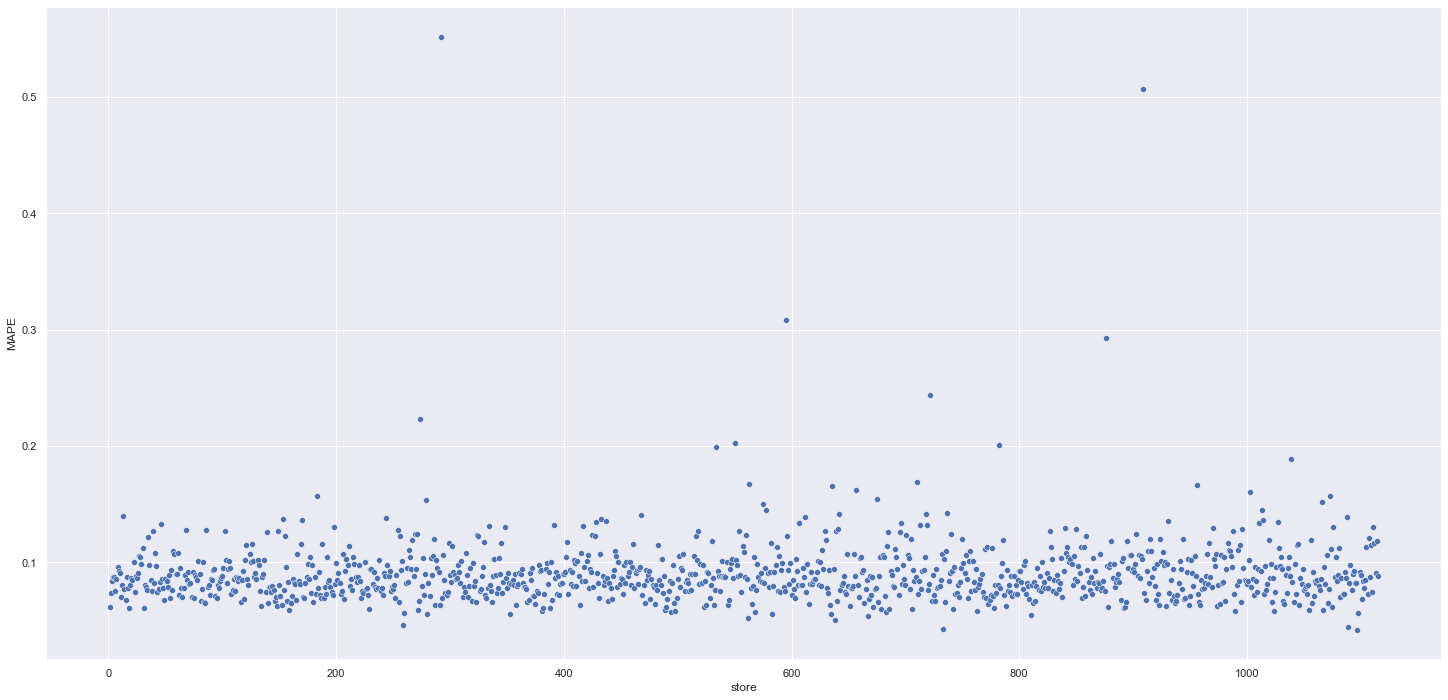

In [87]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [88]:
# Performance total para as próximas 6 semanas
df93 = df92[["predictions", "worst_scenario", "best_scenario"]].apply(
    lambda x: np.sum(x), axis=0).reset_index().rename(
        columns={"index": "Scenario", 0: "Values"})
df93['Values'] = df93['Values'].map('€ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"€ 282,663,616.00"
1,worst_scenario,"€ 281,965,327.15"
2,best_scenario,"€ 283,361,919.71"


## 9.3. Machine Learning Performance

In [89]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

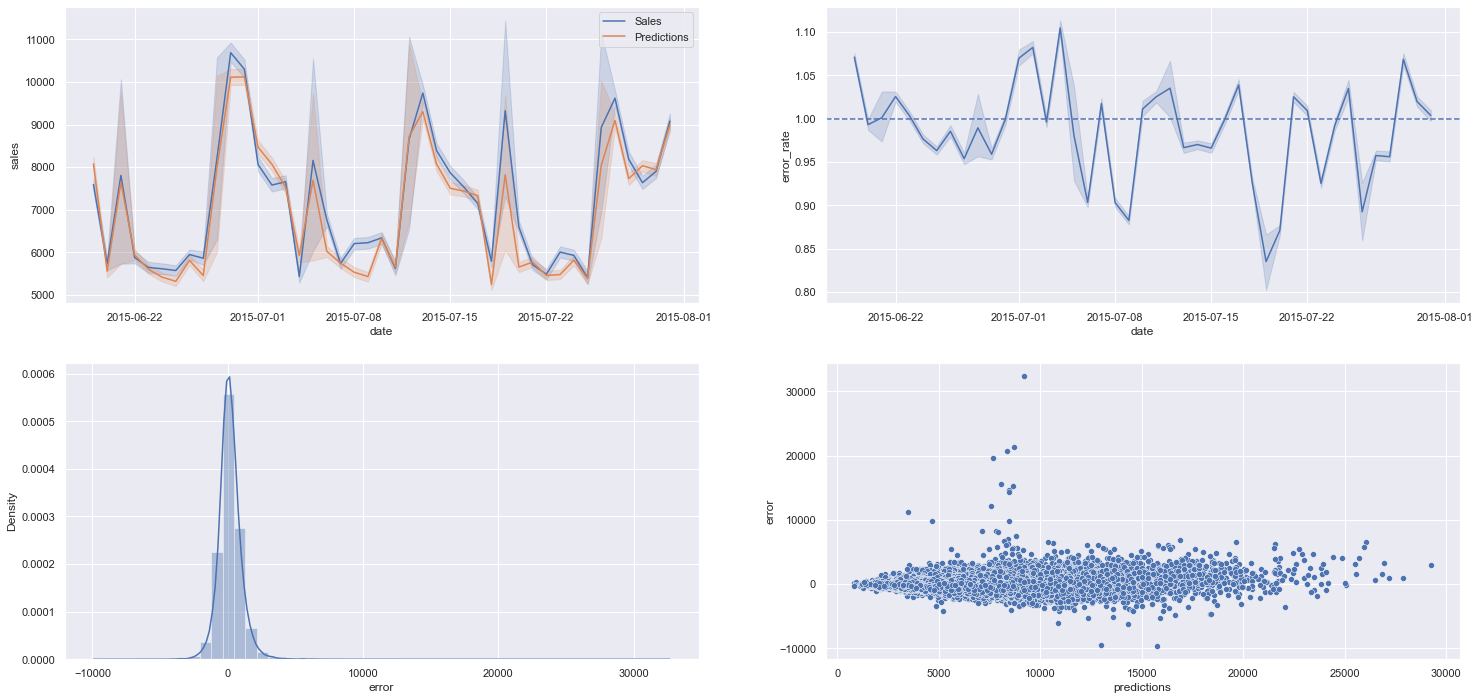

In [93]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales');
sns.lineplot(x='date', y='predictions', data=df9, label='Predictions');

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2, 2, 3)
sns.distplot(df9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTON

In [91]:
# Salvando o modelo escolhido com a biblioteca pickle (serializado)
# para não ser necessário rodar novamente
pickle.dump(xgb_result_tuned, open('../model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [92]:
# Classe Rossmann
Class Rossmann(object):
    def __init__(self):
        state = 1

    def data_cleaning(self, df1):      

        # colunas originais do dataset pego com ctrl-c no columns
        col_old = [ "Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo", "StateHoliday",
                    "SchoolHoliday", "StoreType", "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth",
                    "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval",]

        # Usando a função underscore da biblioteca inflection para substituir camelCase por snake_case
        col_new = list(map(lambda x: inflection.underscore(x), col_old))
        df1.columns = col_new

        df1['date'] = pd.to_datetime(df1['date'])

        # Preenchendo valores faltantes de competition_distance
        df1["competition_distance"] = df1["competition_distance"].apply(
            lambda x: 200000 if math.isnan(x) else x
        )

        # Preenchendo valores faltantes de competition_open_since_month
        df1["competition_open_since_month"] = df1.apply(
            lambda x: x["date"].month
            if math.isnan(x["competition_open_since_month"])
            else x["competition_open_since_month"],
            axis=1,
        )

        # Preenchendo valores faltantes de competition_open_since_year
        df1["competition_open_since_year"] = df1.apply(
            lambda x: x["date"].year
            if math.isnan(x["competition_open_since_year"])
            else x["competition_open_since_year"],
            axis=1,
        )

        # Preenchendo valores faltantes de promo2_since_week
        df1["promo2_since_week"] = df1.apply(
            lambda x: x["date"].week
            if math.isnan(x["promo2_since_week"])
            else x["promo2_since_week"],
            axis=1,
        )

        # Preenchendo valores faltantes de promo2_since_year
        df1["promo2_since_year"] = df1.apply(
            lambda x: x["date"].year
            if math.isnan(x["promo2_since_year"])
            else x["promo2_since_year"],
            axis=1,
        )

        # Preenchendo valores faltantes de promo_interval
        # Criando um dicionário para auxiliar
        # Na aula foi usado Fevereiro == Fev e Setembro == Sep mas
        # no dataset está Fevereiro == Feb e Setembro == Sept
        month_map = {
            1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
            7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec",
        }
        
        # Completa com zeros os valores faltantes
        df1['promo_interval'].fillna(0, inplace=True)
        # Coluna que recebe o mês (num) de df['date'] convertido para a sigla
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        # Recebe 1 caso o mês de month_map esteja em promo_interval caso contrário 0
        df1['is_promo'] = df1.apply(
            lambda x: 0 if x['promo_interval'] == 0 
            else 1 if x['month_map'] in x['promo_interval'].split(',') 
            else 0, 
            axis=1)

        # Alterando os tipos de dados
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

        return df1

## 10.2. API Handler

## 10.3. API Tester